# Выпускной проект. Промышленность.

<font size=3>
    
**Описание проекта**
    

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать.

Заказчик хочет использовать разработанную модель для имитации технологического процесса.
    
**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
    
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
    
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
    
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Описание данных**
    
Данные состоят из нескольких файлов, полученных из разных источников:
- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

    
**План работы**
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Создание признаков и объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

**Требования** 
- метрика `MAE <= 6.8`
- `RANDOM_STATE = 121124`

</font>


In [1]:
#ydata_profiling
#!pip install ydata_profiling
#!pip install --upgrade pip
#!pip install --upgrade Pillow
#!pip install matplotlib==3.7.3
#!pip install shap
#!pip3 install catboost
#!pip install lightgbm

In [168]:
#from ydata_profiling import ProfileReport
#profile = ProfileReport(data_arc, title="geo_data_0_report")
#profile.to_notebook_iframe()

In [169]:
#импорт библиотек
#import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import os as os
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import r2_score
#from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# модели
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

import shap

In [208]:
# Оформление графиков
sns.set(style='darkgrid') 

In [171]:
# Условие проекта
RANDOM_STATE = 121124

## Загрузка данных

In [172]:
# путь к директориям
pth = 'https://code.s3.yandex.net/datasets/'
# загружаем данные
try: 
    data_arc = pd.read_csv(pth + 'data_arc_new.csv')
    data_bulk = pd.read_csv(pth + 'data_bulk_new.csv')
    data_bulk_time = pd.read_csv(pth + 'data_bulk_time_new.csv')
    data_gas = pd.read_csv(pth + 'data_gas_new.csv')
    data_temp = pd.read_csv(pth + 'data_temp_new.csv')
    data_wire = pd.read_csv(pth + 'data_wire_new.csv')
    data_wire_time = pd.read_csv(pth + 'data_wire_time_new.csv')
except:
    print('Something is wrong')

In [173]:
pth = 'https://code.s3.yandex.net/datasets/'

Загрузка данных выполнена успешно.

## Исследовательский анализ и предобработка данных

### Функции

**Создадим функцию `data_info` для знакомства с данными:**

In [174]:
def data_info(data):
    print('Информация о данных:\n')
    print('Data shape:', data.shape,'\n')
    data.info()
    print(f'\nЯвных строк-дубликатов - {data.duplicated().sum()}')
    print('Описание данных:')
    display(data.describe())
    print('\nПервые 20 строк датафрейма:')
    display(data.head(20))
    return 

**Функция `to_snake` для перевода в нижний, змеиный регистр**

In [175]:
def to_snake(words_list): # получает список слов, возвращает список в нижнем, змеином регистре
    snake_register_list = []
    for word in words_list:
        word = word.lower()
        snake_register = ''
        for i in word:
            if i != ' ':
                snake_register += i
            else:
                snake_register += '_'
        snake_register_list.append(snake_register)
    return snake_register_list

**Фунция `hist_dist` для построения гистограммы распределения:**

In [176]:
def hist_dist(data, column_name, bins, i): 
    plt.title(f'{i}. Гистограмма распределения {column_name}', fontsize = 16)
    sns.histplot(data=data, x = column_name, bins=bins, kde=True) #график распределения
    plt.axvline(x=data[column_name].median(), ymin=0.0, ymax=1.0, linewidth=2, alpha = 0.5, color='black') #линия среднего значения
    return

**Фунция `corr_matrix` для построения тепловой карты матрицы корреляции:**

In [177]:
def corr_matrix(data, title, size):
    data_corr = data.corr()
    # строим тепловую карту матрицы
    plt.figure(figsize=(size))
    plt.title(f'Тепловая карта матрицы корреляции признаков датафрейма {title}', fontsize = 18)
    ax = sns.heatmap(data_corr, 
                 annot=True, 
                 fmt=".2f", 
                 linewidth=.1, 
                 vmin=-1, 
                 vmax=1, 
                 center= 0, 
                 cmap= 'coolwarm', 
                 cbar=False);
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize = 14)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize = 14);
    # cbar_kws= {'orientation': 'horizontal'}

### data_arc — данные об электродах

#### Знакомство с данными

In [178]:
data_info(data_arc)

Информация о данных:

Data shape: (14876, 5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Явных строк-дубликатов - 0
Описание данных:


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



Первые 20 строк датафрейма:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [179]:
# Исправляем названия столбцов и типы данных
data_arc.columns = ['key', 
                    'arc_heating_start_time', 
                    'arc_heating_end_time', 
                    'active_power', 
                    'reactive_power']
data_arc['arc_heating_start_time'] = pd.to_datetime(data_arc['arc_heating_start_time'])
data_arc['arc_heating_end_time'] = pd.to_datetime(data_arc['arc_heating_end_time'])
data_arc.head()

,key,arc_heating_start_time,arc_heating_end_time,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


**Описание данных**

- `key` — номер партии;
- `arc_heating_start_time` — время начала нагрева;
- `arc_heating_end_time` — время окончания нагрева;
- `active_power` — значение активной мощности;
- `reactive_power` — значение реактивной мощности.

**Вывод:** 

Пропусков нет, явных строк-дубликатов нет. 
Изменены типы данных и названия столбцов.

#### Исследовательский анализ

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки. Узнаем сколько итераций уходит на обработку.

Среднее количество итераций для обработки металла: 4.63
Всего было партий по data_arc: 3214


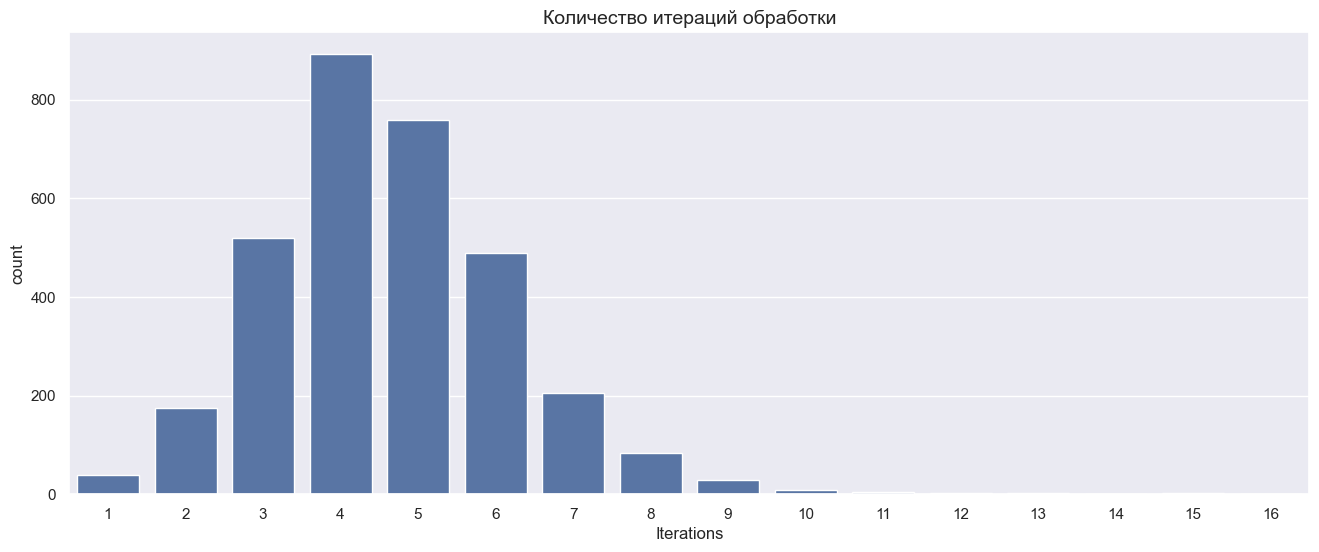

In [207]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x=data_arc.groupby('key')['active_power'].count());
ax.set_xlabel('Iterations');
ax.set_title('Количество итераций обработки', fontsize=14);
print(f'Среднее количество итераций для обработки металла: {round(data_arc.groupby("key")["active_power"].count().mean(),2)}')
print(f"Всего было партий по data_arc: {len(data_arc.groupby('key')['active_power'].count())}")

**Вывод:**

В среднем, для достижения целевого химического состава и оптимальной температуры плавки сталь легируется 4-5 раз. Замечено минимальное значение в столбце `reactive_power = -715` аномалия. Заполним значение средним коэффициентом отношения реактивной и активной мощности.

In [181]:
data_arc[data_arc['reactive_power'] < 0]

,key,arc_heating_start_time,arc_heating_end_time,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [182]:
data_arc.query('key == 2116') # итерация

,key,arc_heating_start_time,arc_heating_end_time,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [183]:
# выберем партию
anom = data_arc.loc[[9778, 9779, 9781]]
anom

,key,arc_heating_start_time,arc_heating_end_time,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [184]:
# коэф изменения активной и реактивной мощности
k = (anom['reactive_power'] / anom['active_power']).mean()
k

0.7716656065216477

In [185]:
#Заполнили средним значением по изменению в партии
data_arc.at[9780, 'reactive_power'] = data_arc.loc[9780]['active_power'] * k

In [186]:
data_arc.query('key == 2116')

,key,arc_heating_start_time,arc_heating_end_time,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,0.544290
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [187]:
#Удалим аномальное значение
#display(data_arc[data_arc['reactive_power'] < 0])
#data_arc.drop(index=data_arc[data_arc['reactive_power'] < 0]. index,inplace=True)
#data_arc[data_arc['reactive_power'] < 0]

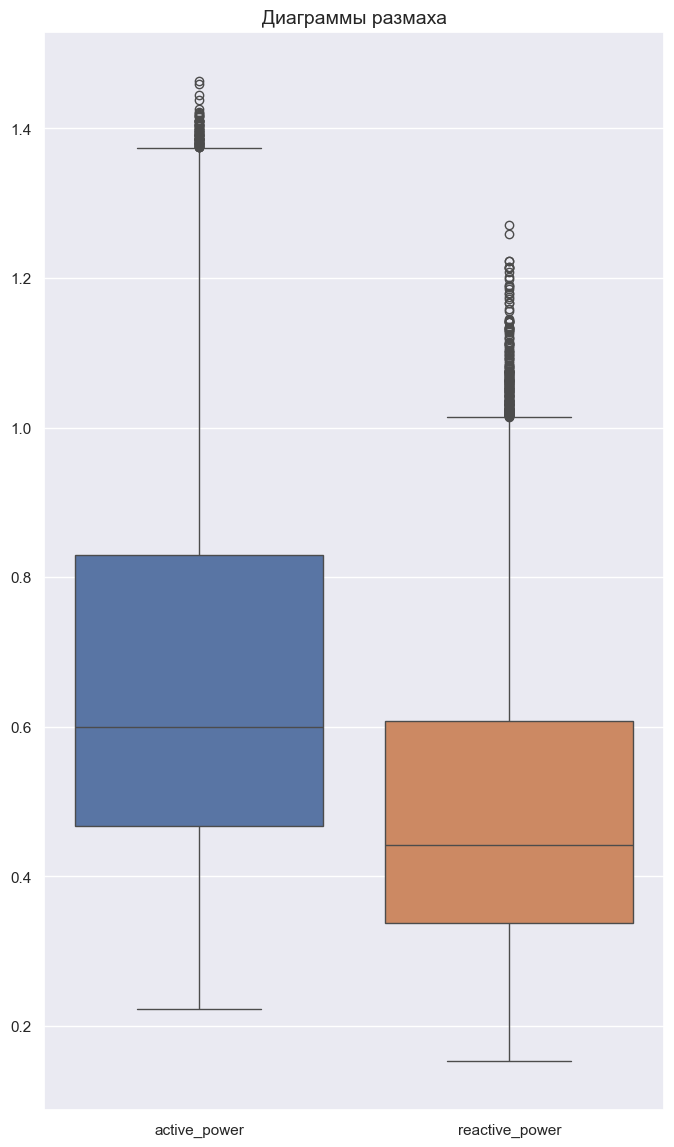

In [188]:
plt.figure(figsize=(8, 14))
sns.boxplot(data=data_arc[['active_power', 'reactive_power']])
plt.title('Диаграммы размаха', fontsize=14);

**Выбросы статистические, не аномальные.**

Построим гистограммы распределения столбцов мощности.

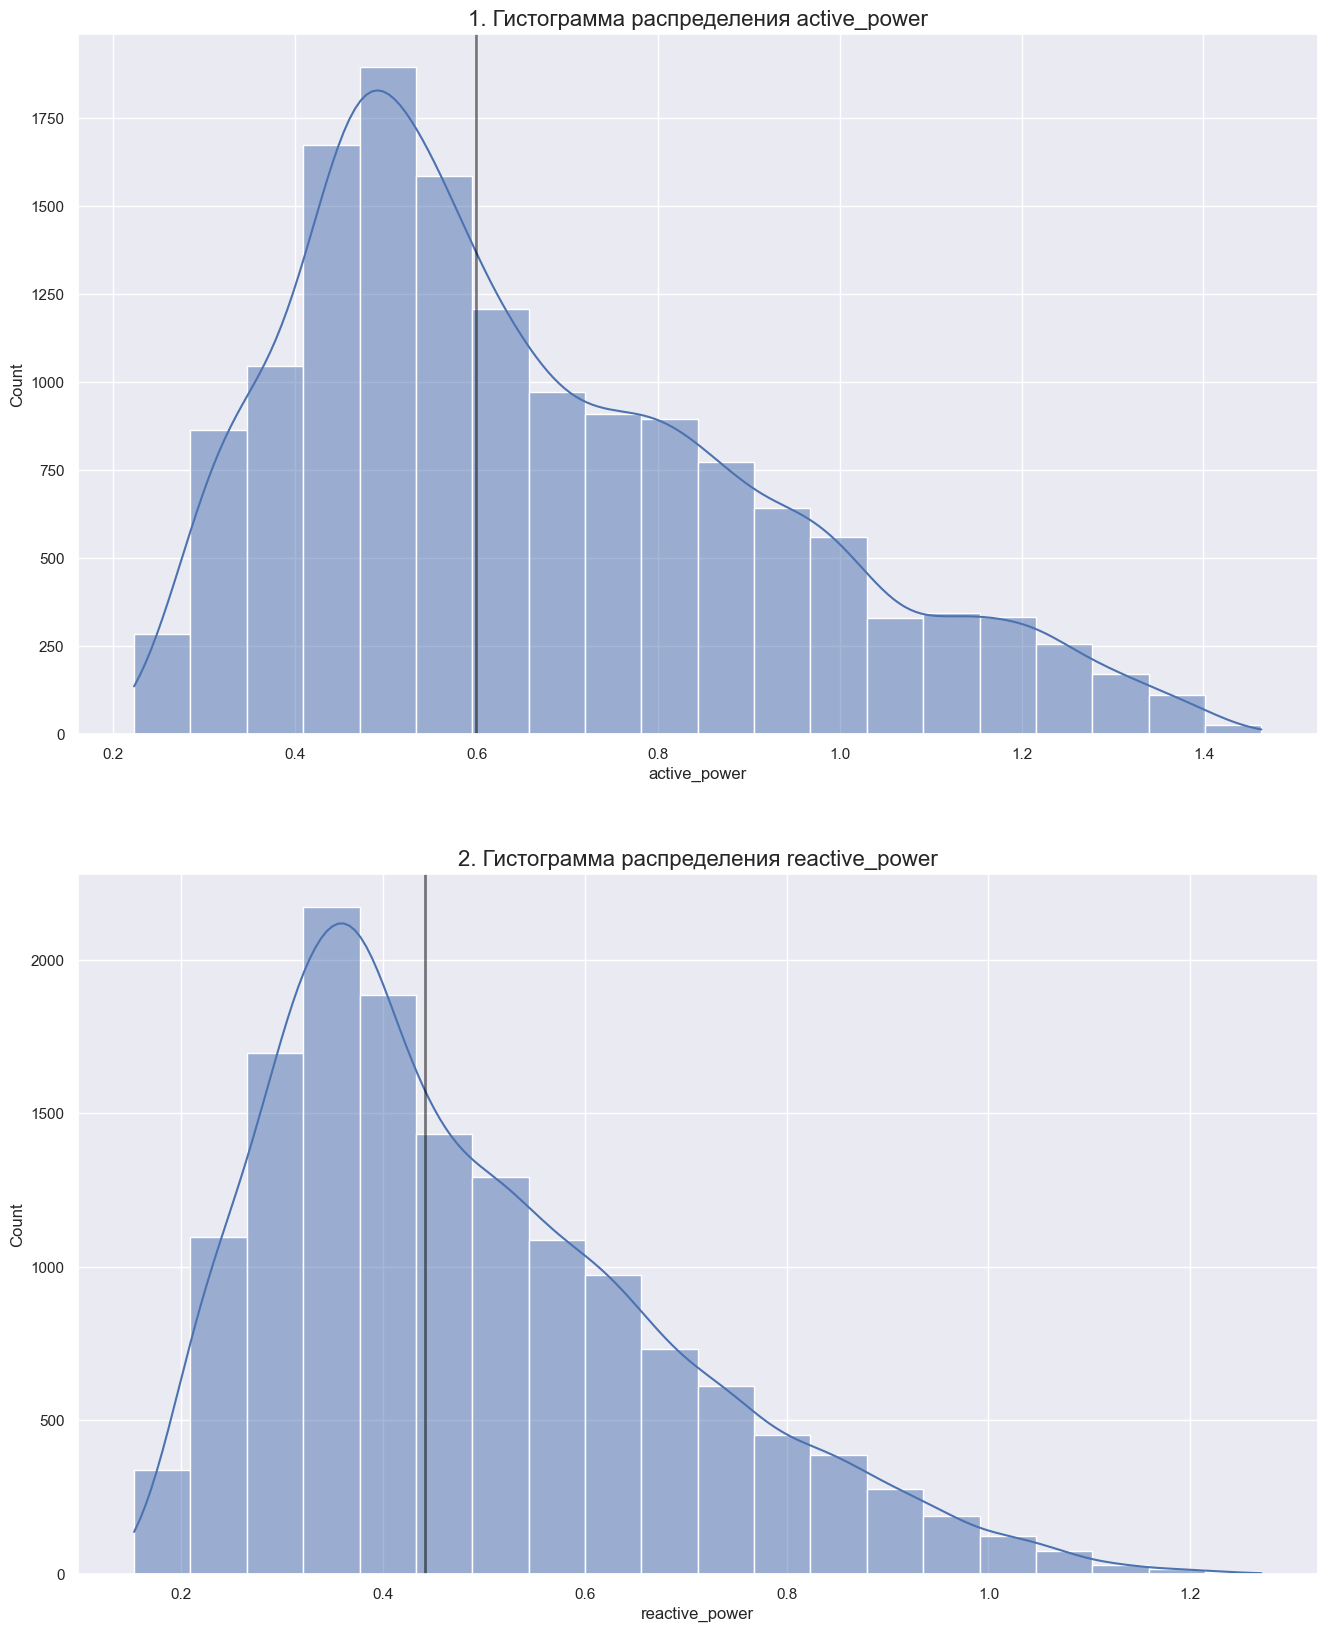

In [189]:
plt.figure(figsize=(16, 20))
bins=20
for i, col_value in enumerate(['active_power', 'reactive_power'], start=1):
    plt.subplot(2, 1, i)
    hist_dist(data_arc, col_value, bins, i)

Нормальное распределение со сдвигом влево, графики очень похожи, нужно проверить корреляцию.

#### Корреляционный анализ

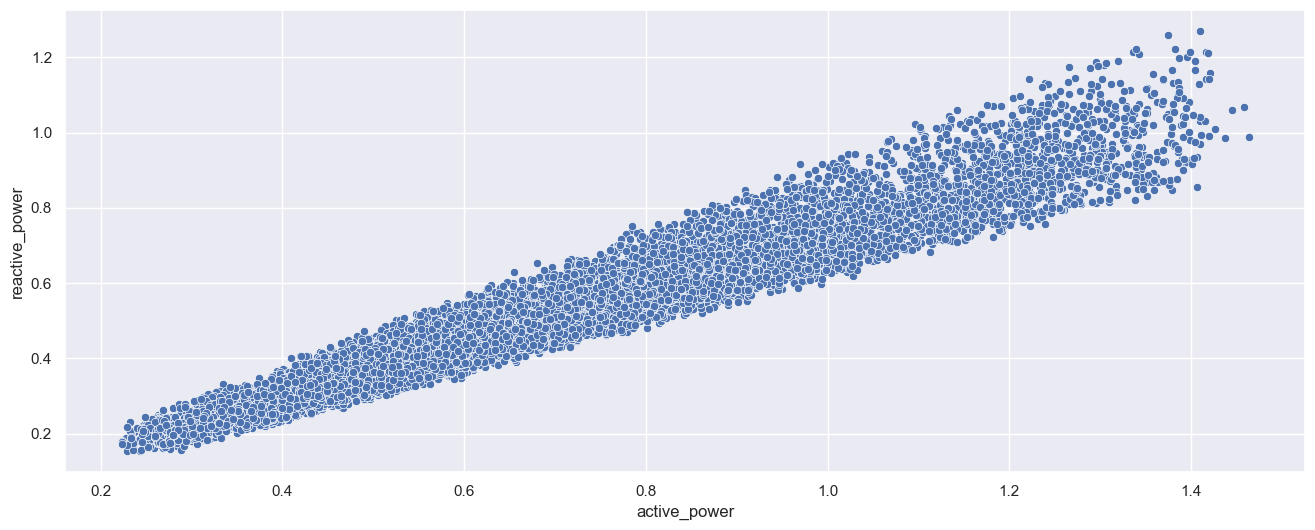

In [190]:
plt.figure(figsize=(16, 6));
sns.scatterplot(data=data_arc, x='active_power', y='reactive_power');

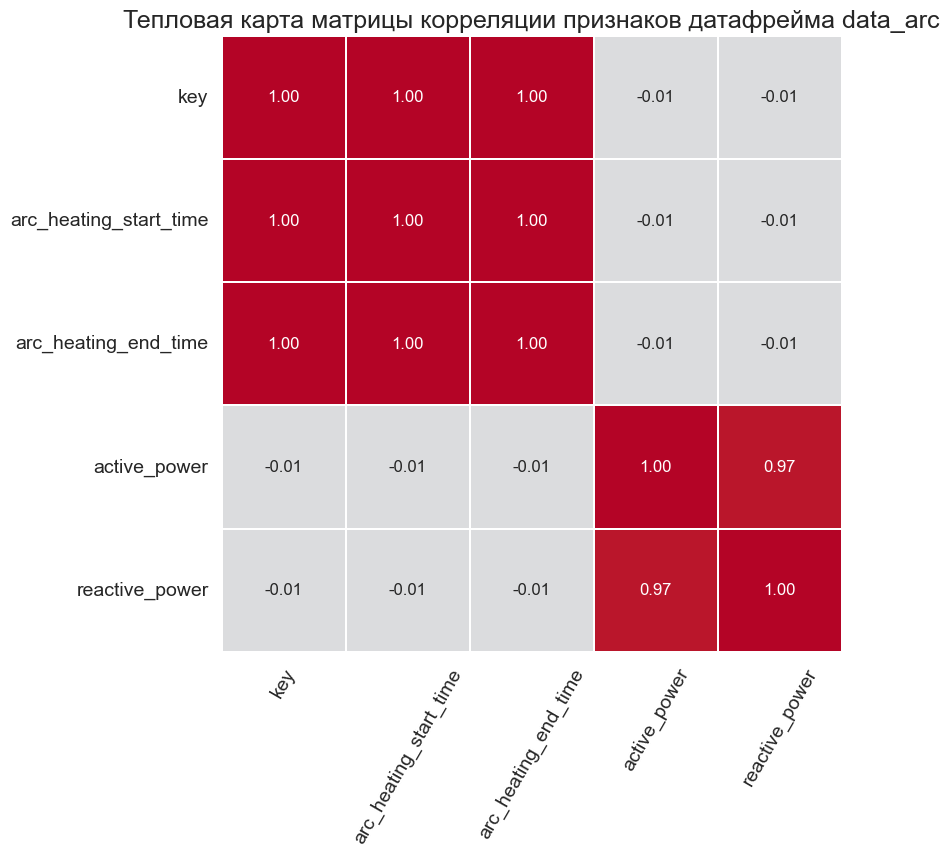

In [191]:
corr_matrix(data_arc, 'data_arc', (8,8))

Сильная корреляция между признакми, можем объединить их в один по физ. формуле:
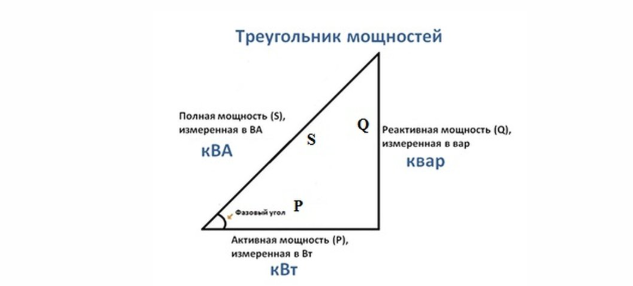
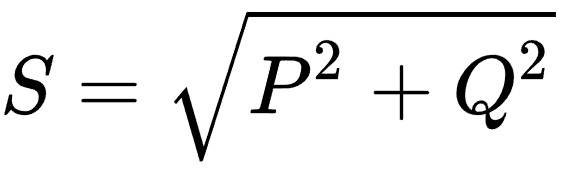
Полная мощность находится как гипотенуза треугольника:

In [192]:
# Находим полную мощность
data_arc['apparent_power'] = (data_arc['active_power'] ** 2 + data_arc['reactive_power'] ** 2) ** 0.5
data_arc.head()

,key,arc_heating_start_time,arc_heating_end_time,active_power,reactive_power,apparent_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934


Проверим:
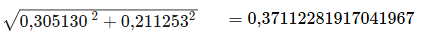
Сошлось.

**Вывод:**

Будет необходимо оставить один признак.

Посмотрим сколько времени греется сплав

In [193]:
timedelta = (data_arc['arc_heating_end_time'] - data_arc['arc_heating_start_time']).dt.total_seconds()
print('Описание данных времени нагрева сплава:')
timedelta.describe()

Описание данных времени нагрева сплава:


count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
dtype: float64

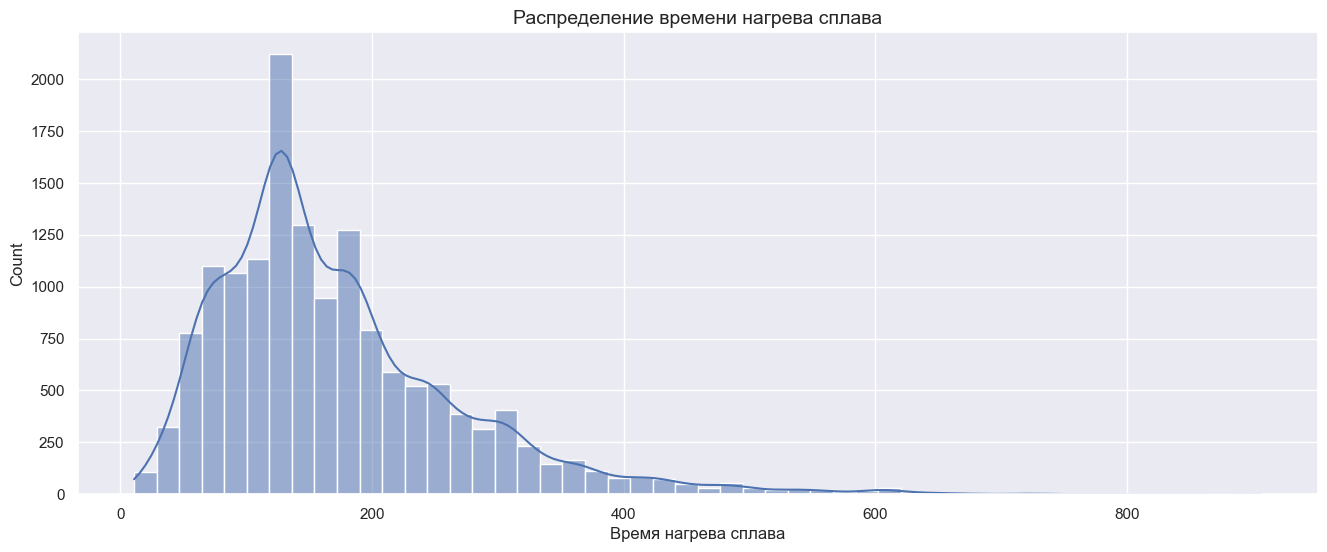

In [194]:
plt.figure(figsize=(16, 6));
ax = sns.histplot(x = timedelta, bins=50, kde=True)
ax.set_xlabel('Время нагрева сплава');
ax.set_title('Распределение времени нагрева сплава', fontsize=14);

**Вывод:**

Теперь знаем, что в среднем сплав греется 3 минуты.

#### Общий вывод

1. Познакомились с данными, пропусков и явных дубликатов не обнаружено.
2. Изменены названия столбцов и типы данных.
3. Узнали среднее количество итераций обработки `~5`. Узнали количество партий по `data_arc: 2443`
4. Удалили единственное отрицательное аномальное значение `-715` в в столбце `reactive_power`.
5. Также замечена сильная корреляция между столбцами `active_power` и `reactive_power`. Посчитано объединяющее значение `apparent_power` для сильно коррелирующих столбцов по физ. формуле, для дальнейшего их удаления.
6. Посчитали разницу между временем и получили новый признак - время нагрева сплава.

### data_bulk — данные о подаче сыпучих материалов (объём)

#### Знакомство с данными

In [195]:
data_info(data_bulk)

Информация о данных:

Data shape: (3129, 16) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB

Явных строк-дубликатов - 0
Описание данных:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Первые 20 строк датафрейма:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [196]:
# исправим регистр столбцов
data_bulk.columns = to_snake(data_bulk.columns)
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


**Описание данных**
- `key` — номер партии;
- `bulk_1 … bulk_15` — объём подаваемого сыпучего материала.

**Вывод:** 

Пропуски есть, явных строк-дубликатов нет. 
Изменены названия столбцов.
Наличие пропусков скорее всего обусловлено методикой работы. Для получения определенного сплава требуется добавление определенных материалов, не всех сразу.

In [197]:
print('Полностью пустых строк:',len(data_bulk) - len(data_bulk.dropna(axis=0, how='all')))

Полностью пустых строк: 0


Пропуски нужно будет заполнить нулями.

#### Исследовательский анализ

Построим гистограммы распределения добавляемых примесей.

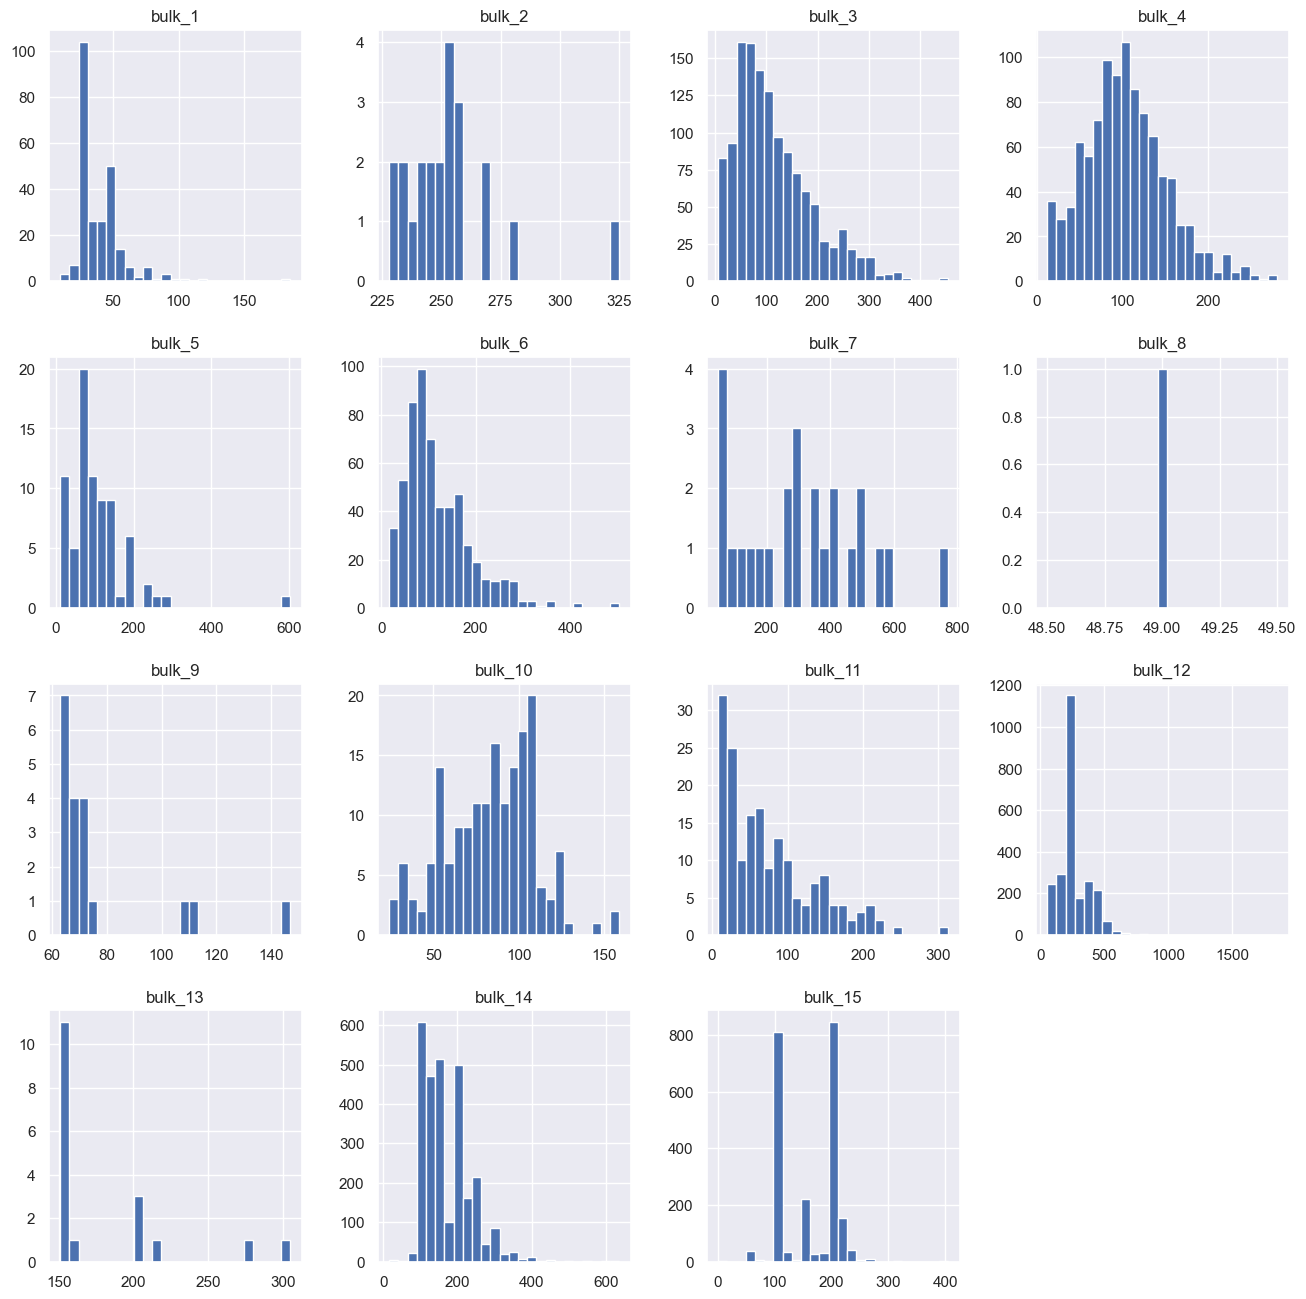

In [198]:
data_bulk.drop('key',axis=1).hist(bins=25, figsize=(16, 16));

**Вывод**

Получили гистограммы распределения количества добавляемого материала. Часть материалов имеет нормальное распределение, часть добавляется в каких то диапазонах: например `bulk_9: 60-80, ~110, ~145` или `bulk_13: ~150, ~210, ~270 и ~300`. Детали можно уточнить у заказчика. Материал `bulk_8` использовался 1 раз, эту деталь тоже хотелось бы уточнить у заказчика, потому что в целом признак можно оставить, т.к. пустые значения будут заполнены `0` и этот столбец не повлияет на модель, однако одного значения не достаточно, чтобы выявить закономерность повышения или понижения температуры.

In [199]:
# Проверим количество значений
data_bulk['bulk_8'].dropna()

1725    49.0
Name: bulk_8, dtype: float64

In [200]:
# Удалим
data_bulk.drop('bulk_8', axis=1, inplace=True)
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Также можем посмотреть частоту использования материалов.

key        3129
Bulk 14    2806
Bulk 12    2450
Bulk 15    2248
Bulk 3     1298
Bulk 4     1014
Bulk 6      576
Bulk 1      252
Bulk 11     177
Bulk 10     176
Bulk 5       77
Bulk 7       25
Bulk 2       22
Bulk 9       19
Bulk 13      18
Bulk 8        1
dtype: int64

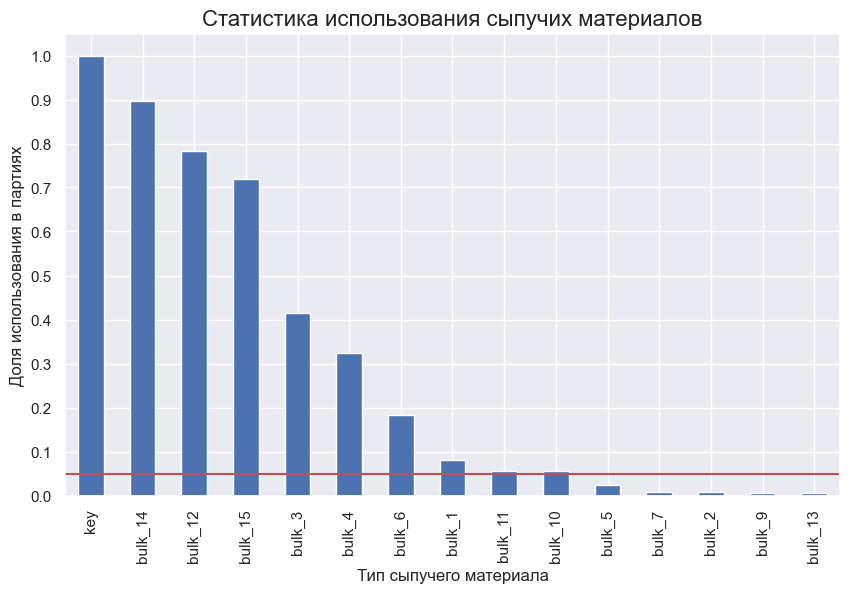

In [201]:
plt.figure(figsize = (10, 6))
ax = data_bulk.notna().mean().sort_values(ascending=False).plot(kind = 'bar')
ax.set_title('Статистика использования сыпучих материалов', fontsize=16)
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип сыпучего материала')
plt.yticks(np.arange(0, 1.1, 0.1));
ax.axhline(y=0.05, color='r', linestyle='-')
data_bulk_time.notna().sum().sort_values(ascending=False)

**Сначала думал удалить часть признаков в силу их количества, но потом подумал, что лучше посмотреть корреляцию и основываясь на ней удалять признаки**

Посмотрим выбросы

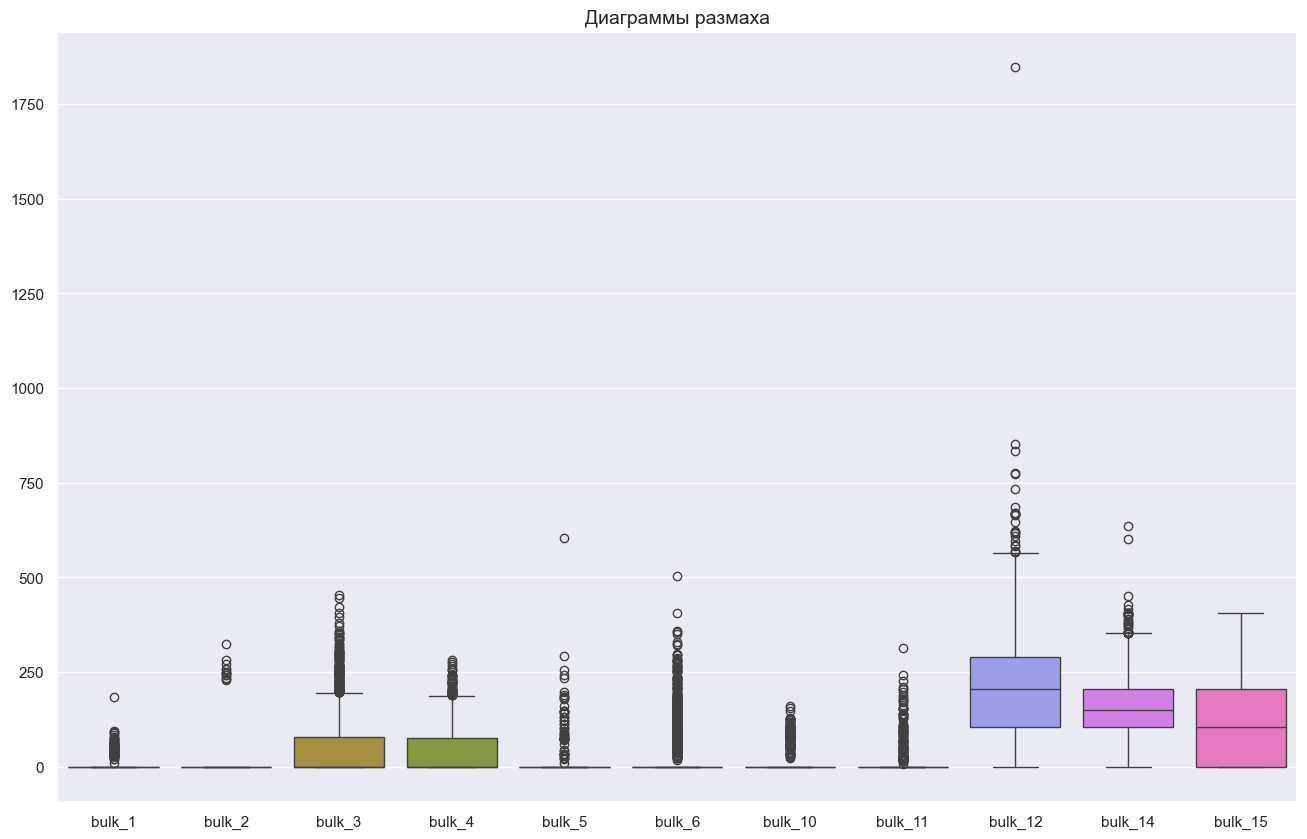

In [165]:
plt.figure(figsize=(16, 10))
sns.boxplot(data=data_bulk.drop('key', axis=1))
plt.title('Диаграммы размаха', fontsize=14);

In [37]:
# Удалим аномалию
#data_bulk.drop(data_bulk.query('bulk_12 > 1000').index, inplace=True)

#### Корреляционный анализ

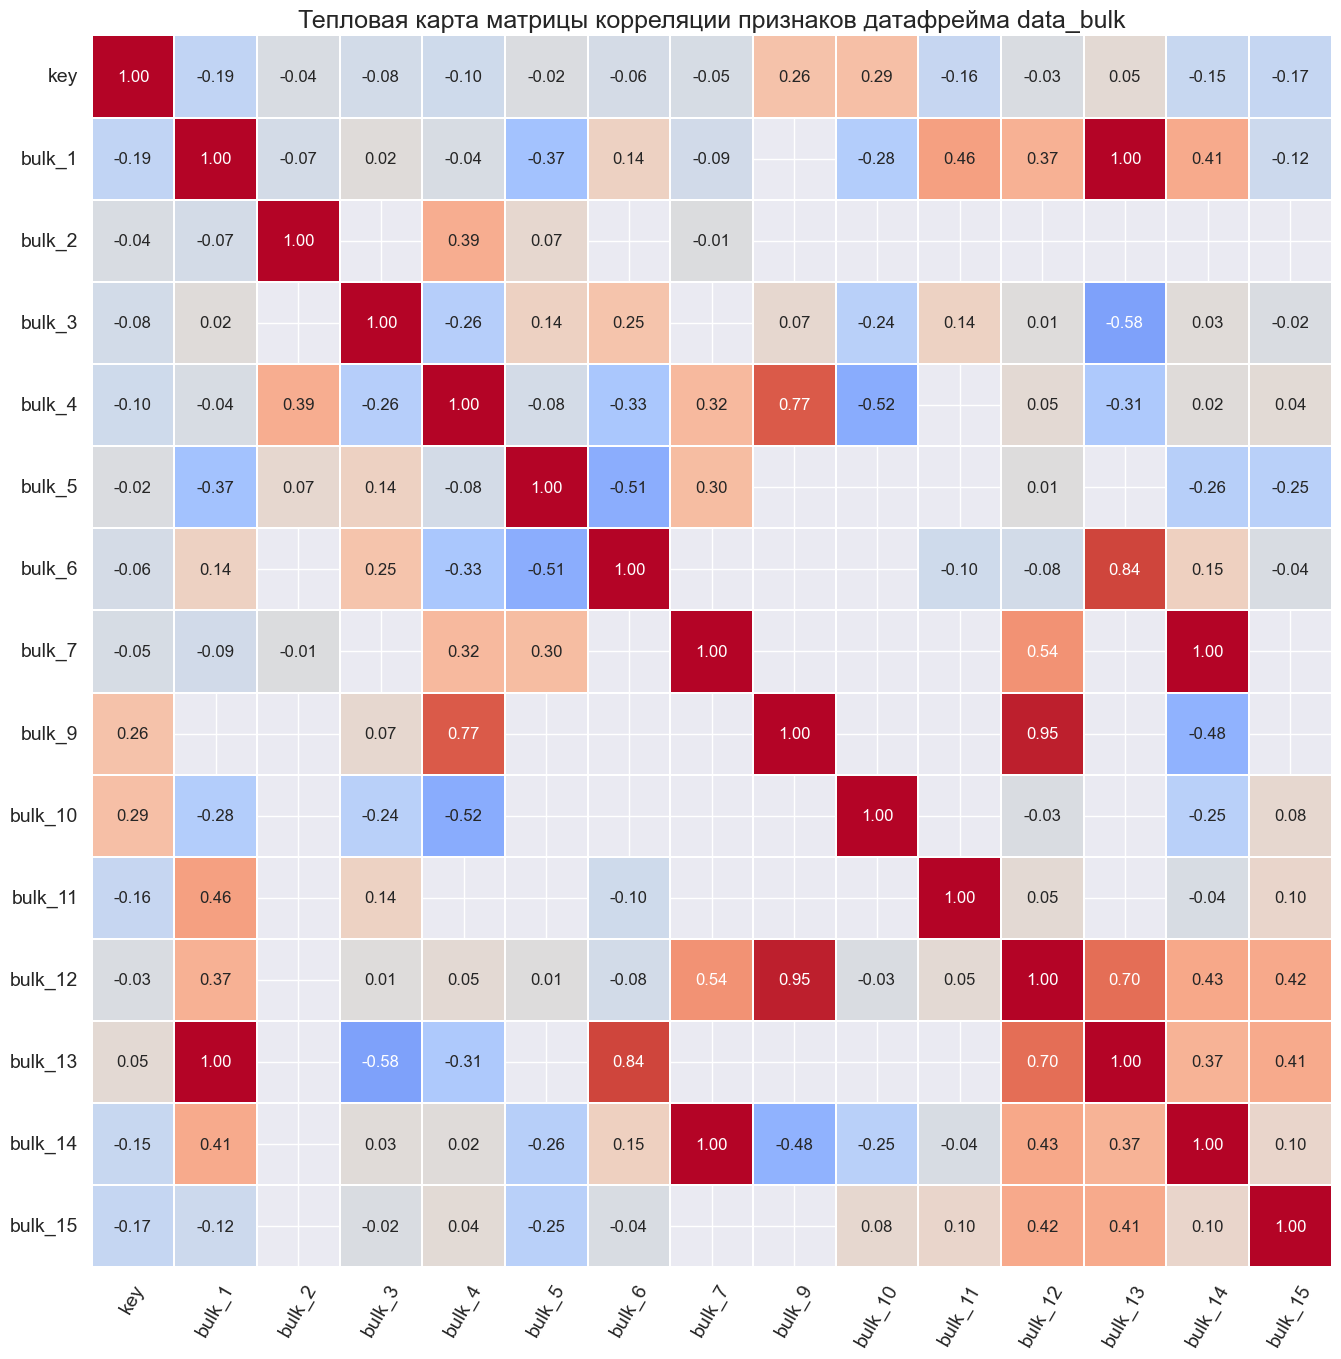

In [38]:
corr_matrix(data_bulk, 'data_bulk', (16,16))

Удалим сильно коррелирующие признаки `k >= 0.9`, основываясь на их количестве.

In [39]:
# Удалим
data_bulk.drop(['bulk_7', 'bulk_9', 'bulk_13'], axis=1, inplace=True)
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,206.0,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,206.0,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,205.0,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,207.0,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,203.0,151.0,152.0


Заполним пропуски нулями. **Создадим функцию заполнения пропусков `data_fill_na`, контролируя пропуска в `key`.**

In [40]:
def data_fill_na(data):
    print('Пропусков в столбце key:', data['key'].isna().sum(),'\n')
    print('Пропуски по ДФ:')
    display(data.isna().sum())
    print('После заполнения:')
    data.fillna(0, inplace=True)
    display(data.isna().sum())
    display(data.head())
    return

In [41]:
data_fill_na(data_bulk)

Пропусков в столбце key: 0 

Пропуски по ДФ:


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_14     323
bulk_15     881
dtype: int64

После заполнения:


key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_14    0
bulk_15    0
dtype: int64

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0


#### Общий вывод

1. Познакомились с данными, обнаружены пропуски, обусловленные спецификой процесса. Явных дубликатов не обнаружено.
2. Изменены названия столбцов.
3. Узнали распределение данных и частоту использования сыпучих материалов. Удалён столбец `bulk_8` в силу количества данных (1 значение).
4. Удалено аномальное значение `> 1750` в столбце `bulk_12`.
5. Также замечена сильная корреляция между `bulk_12`, `bulk_7`, `bulk_9`, `bulk_1`, `bulk_13`. Столбцы `bulk_7`, `bulk_9`, `bulk_13` - удалены.
6. Заполнили пропуски нулями.

### data_bulk_time — данные о подаче сыпучих материалов (время)

#### Знакомство с данными

In [42]:
data_info(data_bulk_time)

Информация о данных:

Data shape: (3129, 16) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB

Явных строк-дубликатов - 0
Описание данных:


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



Первые 20 строк датафрейма:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


In [43]:
# исправим регистр столбцов
data_bulk_time.columns = to_snake(data_bulk_time.columns)
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [44]:
# Исправим время с object на dt
data_bulk_time.iloc[:, 1:16] = data_bulk_time.iloc[:, 1:16].apply(pd.to_datetime)
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [45]:
# Проверим количество значений
data_bulk_time['bulk_8'].dropna()

1725    2019-07-08 17:14:53
Name: bulk_8, dtype: object

In [46]:
# Также одна строка, по индексу свопали, удалим столбец
data_bulk_time.drop('bulk_8', axis=1, inplace=True)
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


**Описание данных**
- `key` — номер партии;
- `bulk_1 … bulk_15` — время подачи сыпучего материала.

**Вывод:** 

Пропуски есть, явных строк-дубликатов нет. 
Изменены названия столбцов и типы данных. Удалили столбец с одним значением.
Наличие пропусков скорее всего обусловлено методикой работы. Для получения определенного сплава требуется добавление определенных материалов, не всех сразу.
Также можно заметить, что во время одной итерации разные материалы подаются в разное время, а не все одновременно.

#### Общий вывод

1. Познакомились с данными, обнаружены пропуски, обусловленные спецификой процесса. Явных дубликатов не обнаружено.
2. Изменены названия столбцов и типы данных.
3. Удалён столбец `bulk_8` в силу количества данных (1 значение).
4. Данные идентичны `data_bulk` и содержат даты добавления материала.

### data_gas — данные о продувке сплава газом

#### Знакомство с данными

In [47]:
data_info(data_gas)

Информация о данных:

Data shape: (3239, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Явных строк-дубликатов - 0
Описание данных:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Первые 20 строк датафрейма:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [48]:
# Исправляем названия столбцов и типы данных
data_gas.columns = ['key', 'gas']

**Описание данных**
- `key` — номер партии;
- `gas` — объём подаваемого газа.

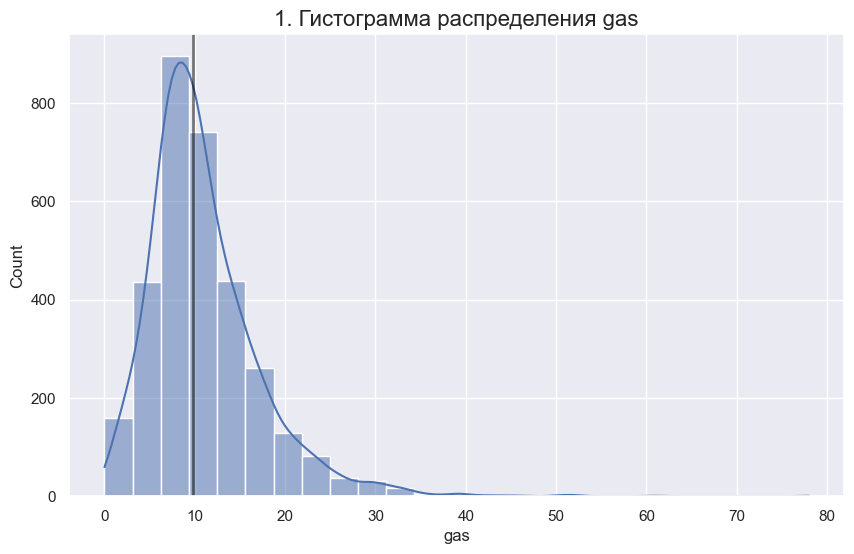

In [49]:
plt.figure(figsize = (10, 6))
hist_dist(data_gas, 'gas', 25, 1)

#### Общий вывод

1. Познакомились с данными, пропусков и явных дубликатов не обнаружено.
2. Изменены название столбца.
3. Узнали распределение значений столбца `gas`.

### data_temp — результаты измерения температуры (target)

#### Знакомство с данными

In [50]:
data_info(data_temp)

Информация о данных:

Data shape: (18092, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

Явных строк-дубликатов - 0
Описание данных:


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000



Первые 20 строк датафрейма:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [51]:
# исправим регистр столбцов
data_temp.columns = ['key', 'datetime', 'temp']
data_temp['datetime'] = pd.to_datetime(data_temp['datetime'])
data_temp.head()

,key,datetime,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


**Описание данных**
- `key` — номер партии;
- `datetime` — время замера;
- `temp` — значение температуры (целевой признак).

Имеются пропуски в таргете, также строк измерений больше, чем в остальных ДФ, т.к. измерения проводились при разных добавлениях и операциях. Пропуски удалим, потому что восстановить их невозможно, по сути это цель проекта - предсказать температуру. Также стоит донести эту информацию до заказчика.

In [52]:
# Удаляем пропуски
data_temp.dropna(subset=['temp'], inplace=True)

#### Исследовательский анализ

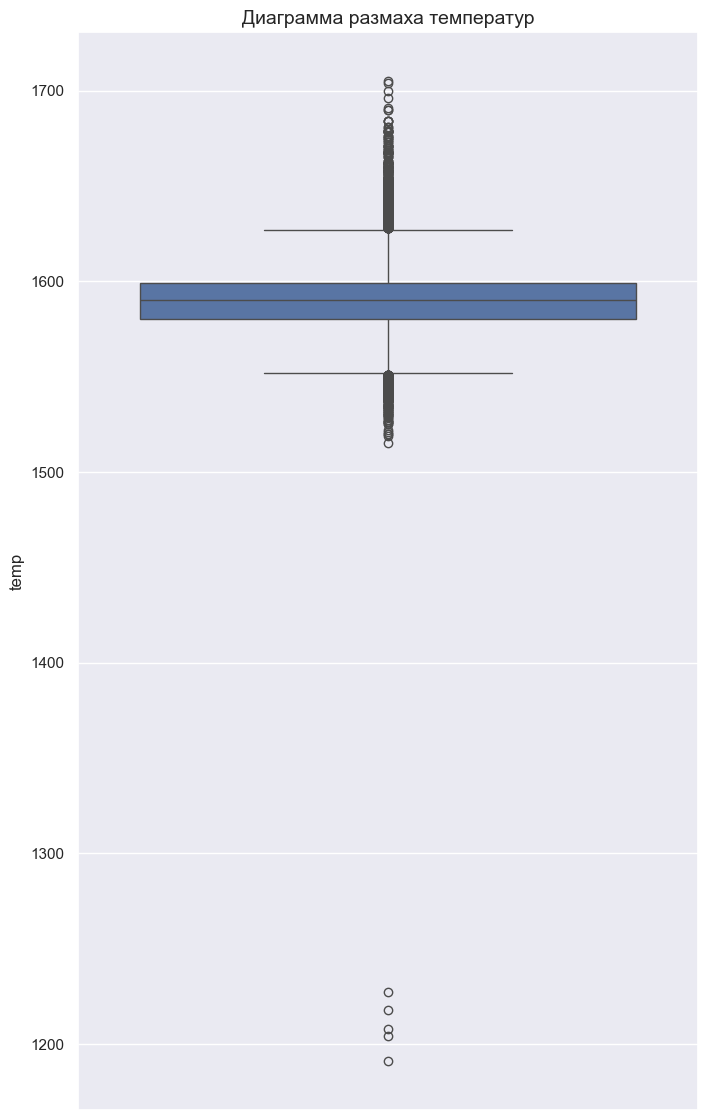

In [53]:
plt.figure(figsize=(8, 14))
sns.boxplot(data=data_temp['temp'])
plt.title('Диаграмма размаха температур', fontsize=14);

Выглядит страшно, но похоже, что данные входят в диапазон температуры плавления стали.

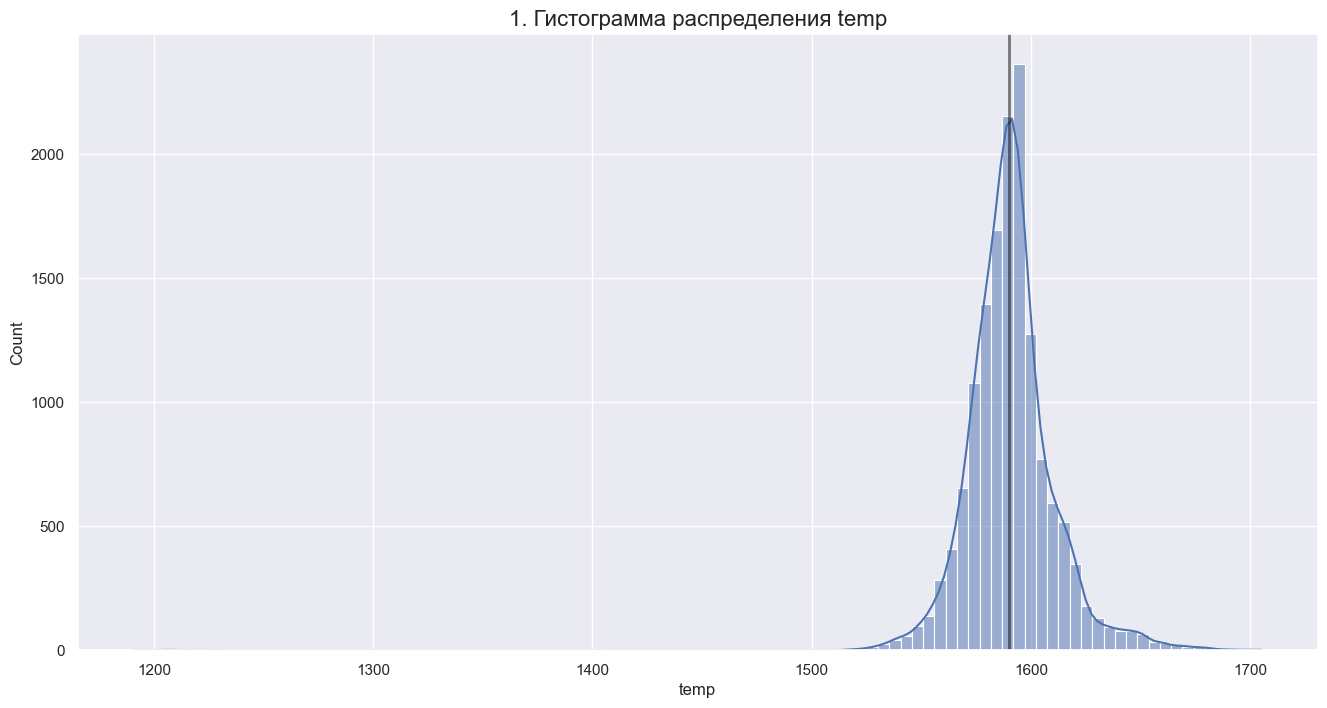

In [54]:
plt.figure(figsize=(16, 8))
bins=100
hist_dist(data_temp, 'temp', bins, 1)

Нормальное распределение.

#### Общий вывод

1. Познакомились с данными, явных дубликатов не обнаружено, пропуски удалены т.к. значения целевые.
2. Изменены названия столбцов и типы данных.
3. Проведён исследовтельский анализ.

### data_wire — данные о проволочных материалах (объём)

#### Знакомство с данными

In [55]:
data_info(data_wire)

Информация о данных:

Data shape: (3081, 10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Явных строк-дубликатов - 0
Описание данных:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Первые 20 строк датафрейма:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# исправим регистр столбцов
data_wire.columns = to_snake(data_wire.columns)
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Описание данных**
- `key` — номер партии;
- `wire_1 … wire_9` — объём подаваемых проволочных материалов.

**Вывод:** 

Пропуски есть, явных строк-дубликатов нет. 
Изменены названия столбцов.
Наличие пропусков скорее всего обусловлено методикой работы. Для получения определенного сплава требуется добавление определенных материалов, не всех сразу.

In [57]:
print('Полностью пустых строк:',len(data_bulk) - len(data_bulk.dropna(axis=0, how='all')))

Полностью пустых строк: 0


#### Исследовательский анализ

Построим гистограммы распределения добавляемых материалов.

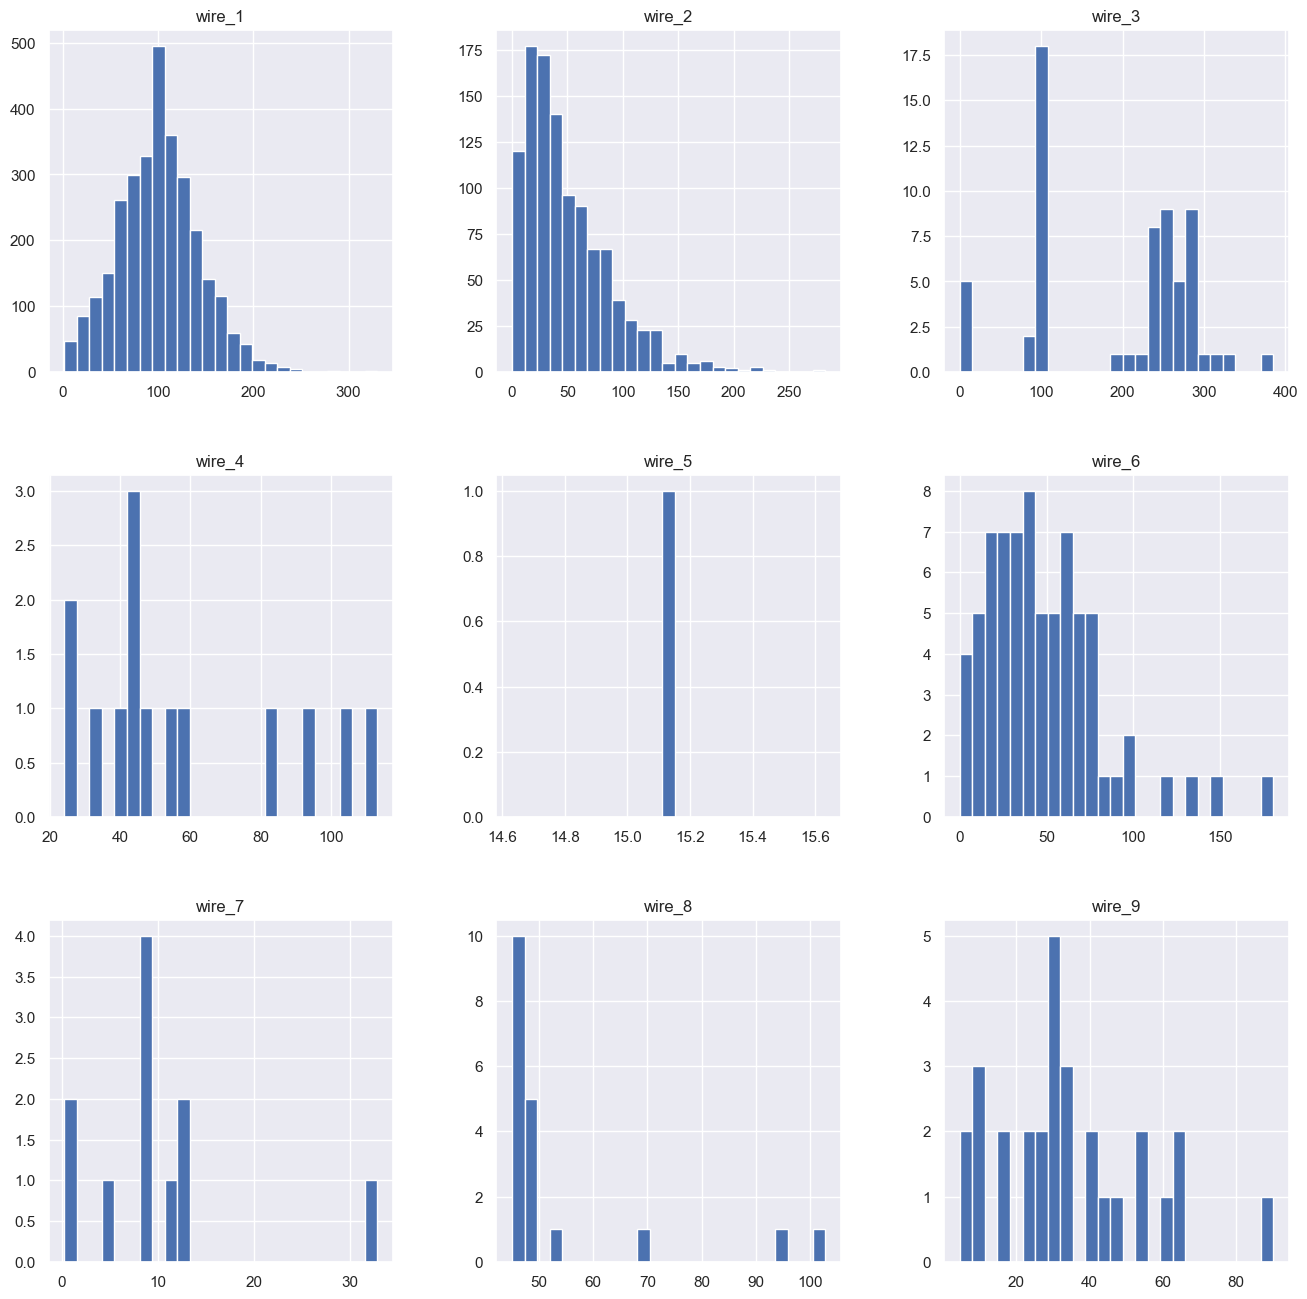

In [58]:
data_wire.drop('key',axis=1).hist(bins=25, figsize=(16, 16));

In [59]:
# Проверим количество значений
data_wire['wire_5'].dropna()

2440    15.132
Name: wire_5, dtype: float64

In [60]:
# Удалим
data_wire.drop('wire_5', axis=1, inplace=True)
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN


key        3129
bulk_14    2806
bulk_12    2450
bulk_15    2248
bulk_3     1298
bulk_4     1014
bulk_6      576
bulk_1      252
bulk_11     177
bulk_10     176
bulk_5       77
bulk_7       25
bulk_2       22
bulk_9       19
bulk_13      18
dtype: int64

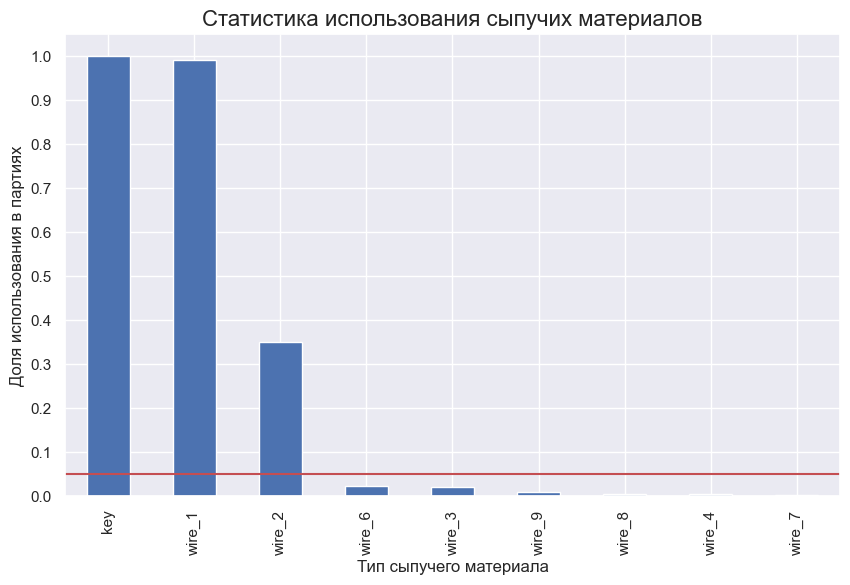

In [61]:
plt.figure(figsize = (10, 6))
ax = data_wire.notna().mean().sort_values(ascending=False).plot(kind = 'bar')
ax.set_title('Статистика использования сыпучих материалов', fontsize=16)
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип сыпучего материала')
plt.yticks(np.arange(0, 1.1, 0.1));
ax.axhline(y=0.05, color='r', linestyle='-')
data_bulk_time.notna().sum().sort_values(ascending=False)

Проверим выбросы

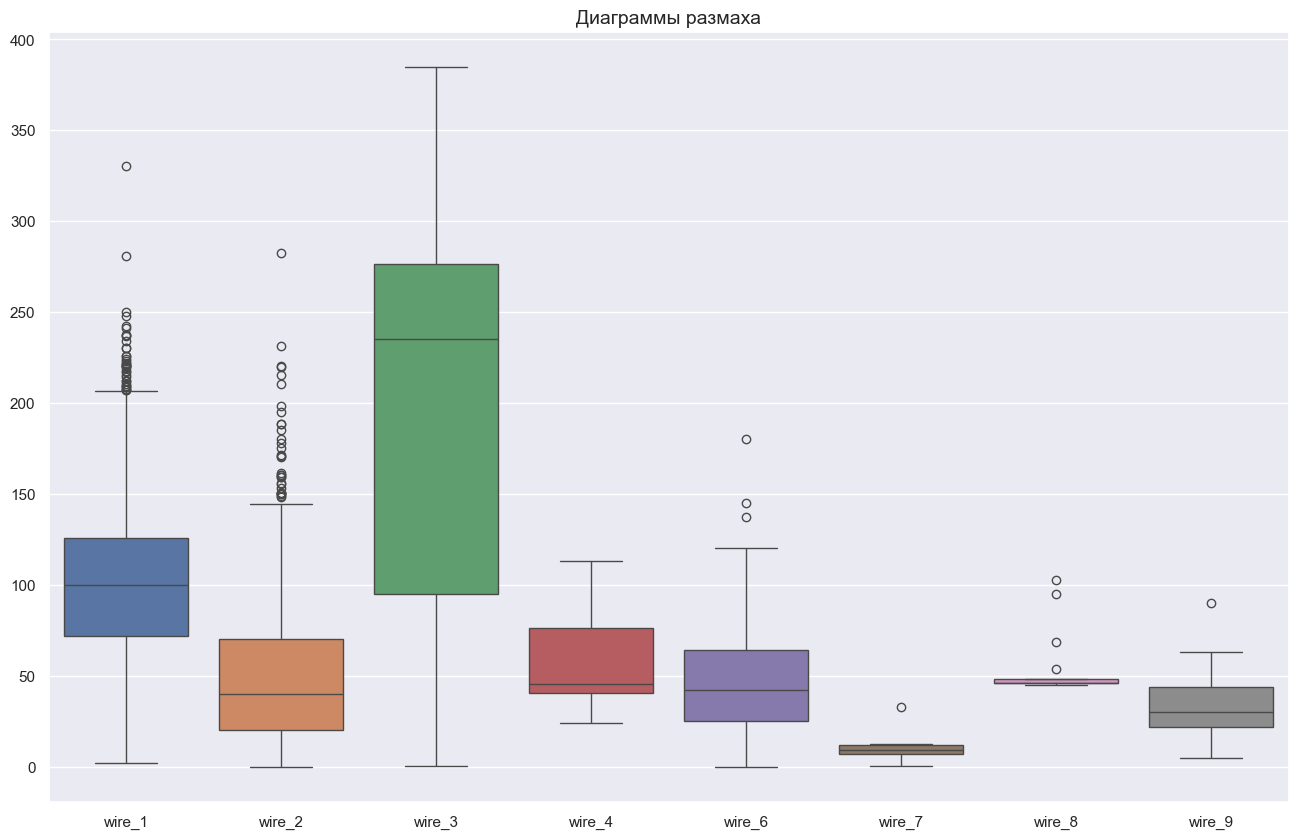

In [62]:
plt.figure(figsize=(16, 10))
sns.boxplot(data=data_wire.drop('key', axis=1))
plt.title('Диаграммы размаха', fontsize=14);

Вроде не аномально.

In [63]:
data_fill_na(data_wire)

Пропусков в столбце key: 0 

Пропуски по ДФ:


key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

После заполнения:


key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


#### Корреляционный анализ

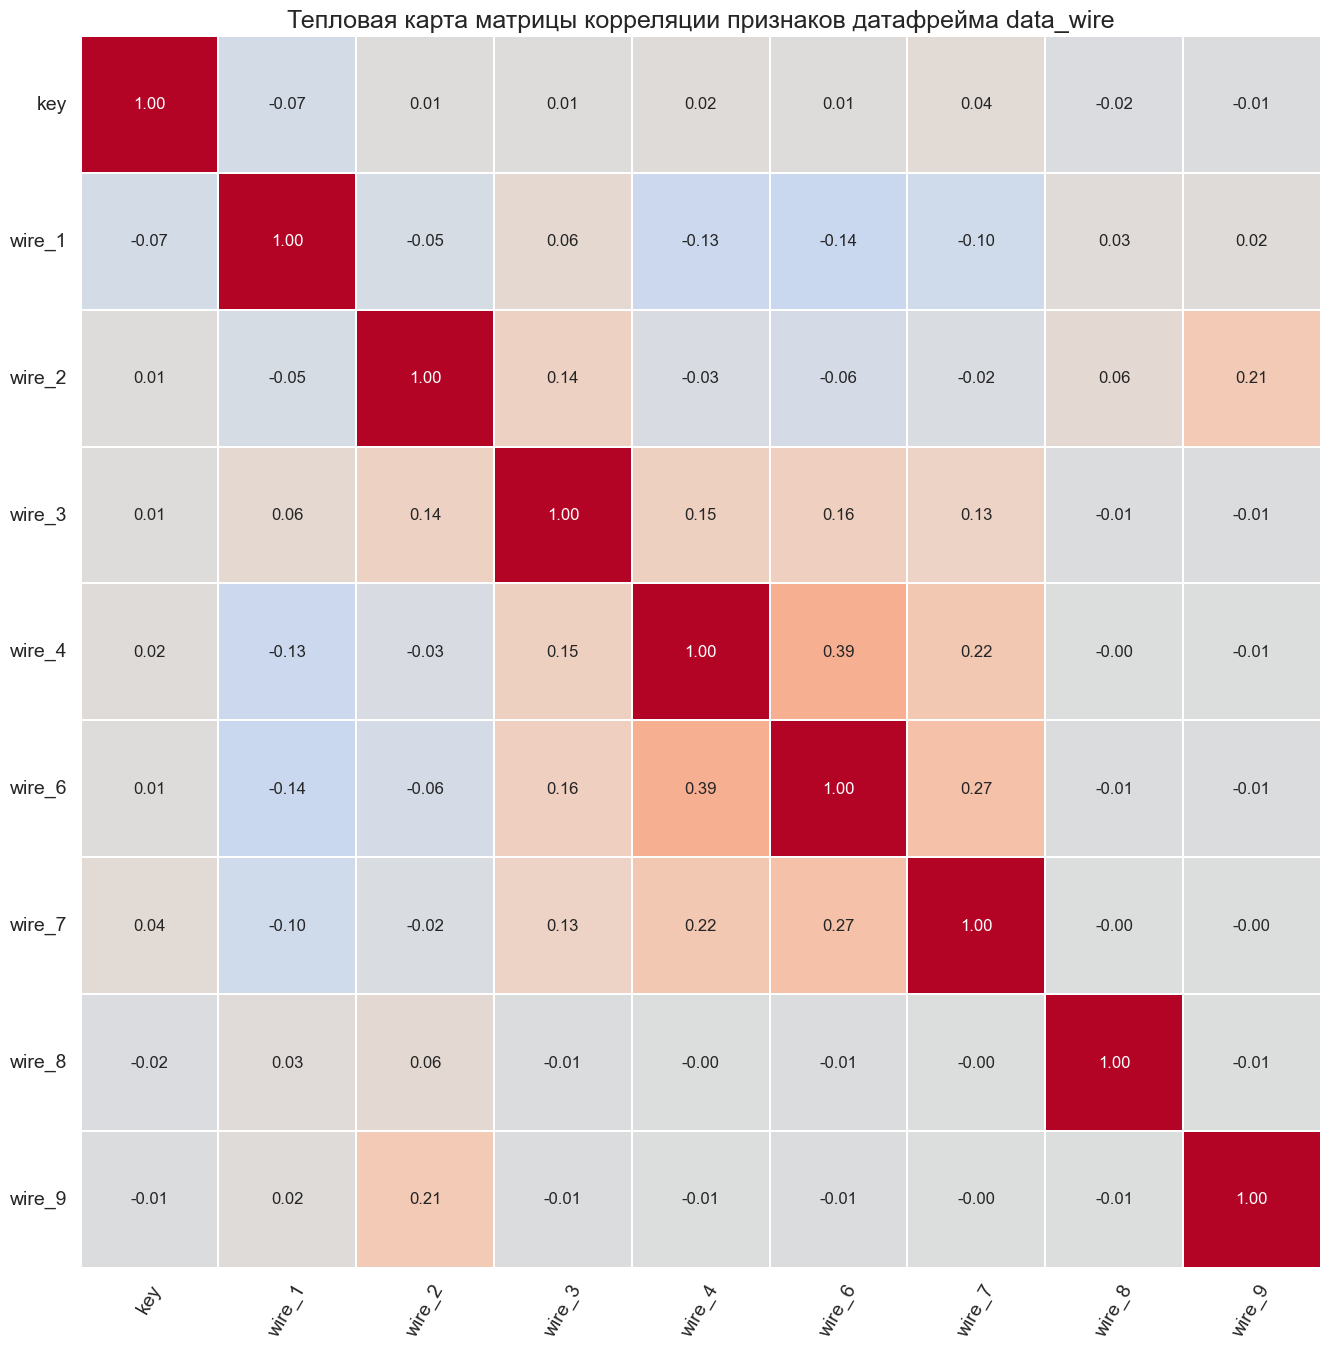

In [64]:
corr_matrix(data_wire, 'data_wire', (16,16))

В норме

Заполним пропуски нулями.

In [65]:
data_fill_na(data_wire)

Пропусков в столбце key: 0 

Пропуски по ДФ:


key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

После заполнения:


key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


#### Общий вывод

1. Познакомились с данными, обнаружены пропуски, обусловленные спецификой процесса. Явных дубликатов не обнаружено.
2. Изменены названия столбцов.
3. Узнали распределение данных и частоту использования проволочных материалов. Удалён столбец `wire_5` в силу количества данных (1 значение).
4. Заполнили пропуски нулями.

### data_wire_time — данные о проволочных материалах (время)

#### Знакомство с данными

In [66]:
data_info(data_wire_time)

Информация о данных:

Data shape: (3081, 10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Явных строк-дубликатов - 0
Описание данных:


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



Первые 20 строк датафрейма:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# исправим регистр столбцов
data_wire_time.columns = to_snake(data_wire_time.columns)
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# Исправим время с object на dt
data_wire_time.iloc[:, 1:9] = data_wire_time.iloc[:, 1:9].apply(pd.to_datetime)
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaN


In [69]:
# Проверим количество значений
data_wire_time['wire_5'].dropna()

2440    2019-08-13 06:14:30
Name: wire_5, dtype: object

In [70]:
# Также одна строка, по индексу свопали, удалим столбец
data_wire_time.drop('wire_5', axis=1, inplace=True)
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaN
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaN
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaN
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaN


**Описание данных**
- `key` — номер партии;
- `wire_1 … wire_9` — время подачи материала.

**Вывод:** 

Пропуски есть, явных строк-дубликатов нет. 
Изменены названия столбцов и типы данных. Удалили столбец с одним значением.
Наличие пропусков скорее всего обусловлено методикой работы. Для получения определенного сплава требуется добавление определенных материалов, не всех сразу.
Также можно заметить, что во время одной итерации разные материалы подаются в разное время, а не все одновременно.

### Вывод по предобработке

1. Проведён первичный анализ и знакомство с данными.
2. Исправлены типы данных и названия столбцов.
3. Проверено отсутствие строк-дубликатов и пропусков. В датафреймах `data_bulk` и `data_wire` пропуски заполнены нулями, т.к. они обусловлены спецификой процесса и ведения таблицы.
4. Удалены аномалии
5. Проведен исследовательский и корреляционный анализ. Сильно коррелирующий столбцы удалены или объединены.

## Создание признаков и объединение данных

По требованию заказчика нам нужно предсказывать последнюю температуру в партии, поэтому создадим 3 новых признака:
1. Начальная температура в партии.
2. Средняя температура, за исключением последнего измерения.
3. Последнее измерение температуры (таргет).

Также по требованию заказчика не нужно предсказывать работы с `<=2` итерациями `key`.

### data_temp

In [71]:
data_temp.shape

(14665, 3)

In [72]:
# Группируем данные по key
data_grouped_key = data_temp.groupby('key').count()
print(data_grouped_key.shape)
data_grouped_key.head()

(3216, 2)


,datetime,temp
key,,
1,6,6
2,5,5
3,6,6
4,5,5
5,5,5


In [73]:
# Получаем key > 2
data_keys = data_grouped_key[data_grouped_key['temp'] > 2].index
# Оставляем только те работы, у которых key.count > 2
data_temp.query('key in @data_keys', inplace=True)
data_temp.shape

(13860, 3)

In [74]:
(data_temp.query('key == 1')['temp'].sum() - data_temp.query('key == 1')['temp'].iloc[-1]) / len(data_temp.query('key == 1')['temp'])

1333.3333333333333

In [75]:
data_temp.query('key == 1')

,key,datetime,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0


In [76]:
%%time
temp_start = []
temp_end = []
temp_avg = []
for i in data_temp['key'].unique():
    data = data_temp.query('key == @i').sort_values(by='datetime') # дф с key = i
    temp_start.append(data['temp'].iloc[0]) # нач
    temp_end.append(data['temp'].iloc[-1]) # конеч
    temp_avg.append((data['temp'].sum() - data['temp'].iloc[-1])/(len(data['temp'])-1))

CPU times: total: 1.52 s
Wall time: 1.52 s


In [77]:
data_temp_old = data_temp

In [78]:
data_temp = pd.DataFrame({'key':data_keys, 
                          'temp_start':temp_start, 
                          'temp_end':temp_end, 
                          'temp_avg':temp_avg})
data_temp.shape

(2443, 4)

In [79]:
data_temp.head(20)

,key,temp_start,temp_end,temp_avg
0,1,1571.0,1613.0,1600.000000
1,2,1581.0,1602.0,1587.750000
2,3,1596.0,1599.0,1598.000000
3,4,1601.0,1625.0,1614.750000
4,5,1576.0,1602.0,1585.750000
5,6,1543.0,1596.0,1581.000000
6,7,1586.0,1599.0,1590.500000
7,8,1577.0,1598.0,1595.250000
8,9,1587.0,1592.0,1589.600000
9,10,1574.0,1593.0,1582.833333


In [80]:
data_temp_old.head(30)

,key,datetime,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Продолжим формирование таблицы отталкиваясь от таргета.

### data_arc

1. Из данных по времени выделим среднее время нагрева, минимальное и максимальное значение. Утечки данных быть не должно, т.к. при грубом анализе между замером температуры и отключением нагрева проходит 1-2 минуты.
2. Также выведем среднее, минимальное и максимальное значение полной мощности.

Создаем признаки для последующего объединения

In [81]:
data_arc['timedelta'] = timedelta # timedelta см п. 2.1
print(data_arc.shape)
data_arc.head()

(14876, 7)


,key,arc_heating_start_time,arc_heating_end_time,active_power,reactive_power,apparent_power,timedelta
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0


In [82]:
data_arc.query('key in @data_keys', inplace=True) #data_keys п. 3.1
data_arc.shape

(11417, 7)

In [83]:
data_arc_grouped = data_arc.groupby('key').agg(
                            min_apparent_power=('apparent_power', 'min'), 
                            max_apparent_power=('apparent_power', 'max'), 
                            mean_apparent_power=('apparent_power', 'mean'),
                            min_timedelta=('timedelta', 'min'), 
                            max_timedelta=('timedelta', 'max'), 
                            mean_timedelta=('timedelta', 'mean')).reset_index()
print(data_arc_grouped.shape)
data_arc_grouped.head()

(2443, 7)


,key,min_apparent_power,max_apparent_power,mean_apparent_power,min_timedelta,max_timedelta,mean_timedelta
0,1,0.371123,1.079934,0.743747,148.0,365.0,219.60
1,2,0.332731,0.955315,0.647087,126.0,338.0,202.75
2,3,0.502111,1.497189,1.003845,65.0,280.0,131.00
3,4,0.393685,1.097105,0.850010,99.0,278.0,185.25
4,5,0.428064,1.110873,0.704245,71.0,415.0,217.25


In [84]:
#pivot = pd.pivot_table(data_arc, index='key', values=['active_power','reactive_power','timedelta'], aggfunc=['min','max','mean'])

Оставшиеся датафреймы прогоним через фильтр `key` нужных заказчику работ. ДФ `data_wire_time` и `data_bulk_time` в нашем случае не понадобятся.

**Создадим функцию `key_filter` для обработки ДФ по нужным ключам.**

In [85]:
def key_filter(data):
    print('Shape before:', data.shape)
    data.query('key in @data_keys', inplace=True), print('Shape after:', data.shape) #data_keys п. 3.1
    return

In [86]:
key_filter(data_bulk)

Shape before: (3129, 12)
Shape after: (2382, 12)


In [87]:
key_filter(data_gas)

Shape before: (3239, 2)
Shape after: (2441, 2)


In [88]:
key_filter(data_wire)

Shape before: (3081, 9)
Shape after: (2341, 9)


Возникли различия в количестве строк т.к. в некоторых партиях могли добавляться только проволочные или только сыпучие материалы.

### Объединение 

Создадим функцию `data_merge` для аккуратного объединения дф)

In [89]:
def data_merge(data1, data2):
    print(f'data 1 shape: {data1.shape}\ndata 2 shape: {data2.shape}')
    data_return = data1.merge(data2, on='key', how='inner')
    print(f'data merged shape: {data_return.shape}')
    display(data_return.head())
    return data_return

In [90]:
data_final = data_merge(data_temp, data_arc_grouped)

data 1 shape: (2443, 4)
data 2 shape: (2443, 7)
data merged shape: (2443, 10)


,key,temp_start,temp_end,temp_avg,min_apparent_power,max_apparent_power,mean_apparent_power,min_timedelta,max_timedelta,mean_timedelta
0,1,1571.0,1613.0,1600.00,0.371123,1.079934,0.743747,148.0,365.0,219.60
1,2,1581.0,1602.0,1587.75,0.332731,0.955315,0.647087,126.0,338.0,202.75
2,3,1596.0,1599.0,1598.00,0.502111,1.497189,1.003845,65.0,280.0,131.00
3,4,1601.0,1625.0,1614.75,0.393685,1.097105,0.850010,99.0,278.0,185.25
4,5,1576.0,1602.0,1585.75,0.428064,1.110873,0.704245,71.0,415.0,217.25


In [91]:
data_final = data_merge(data_final, data_bulk)

data 1 shape: (2443, 10)
data 2 shape: (2382, 12)
data merged shape: (2382, 21)


,key,temp_start,temp_end,temp_avg,min_apparent_power,max_apparent_power,mean_apparent_power,min_timedelta,max_timedelta,mean_timedelta,...,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15
0,1,1571.0,1613.0,1600.00,0.371123,1.079934,0.743747,148.0,365.0,219.60,...,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,1581.0,1602.0,1587.75,0.332731,0.955315,0.647087,126.0,338.0,202.75,...,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,1596.0,1599.0,1598.00,0.502111,1.497189,1.003845,65.0,280.0,131.00,...,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,1601.0,1625.0,1614.75,0.393685,1.097105,0.850010,99.0,278.0,185.25,...,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,1576.0,1602.0,1585.75,0.428064,1.110873,0.704245,71.0,415.0,217.25,...,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0


In [92]:
data_final = data_merge(data_final, data_gas)

data 1 shape: (2382, 21)
data 2 shape: (2441, 2)
data merged shape: (2380, 22)


,key,temp_start,temp_end,temp_avg,min_apparent_power,max_apparent_power,mean_apparent_power,min_timedelta,max_timedelta,mean_timedelta,...,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,gas
0,1,1571.0,1613.0,1600.00,0.371123,1.079934,0.743747,148.0,365.0,219.60,...,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,1587.75,0.332731,0.955315,0.647087,126.0,338.0,202.75,...,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,1598.00,0.502111,1.497189,1.003845,65.0,280.0,131.00,...,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,1614.75,0.393685,1.097105,0.850010,99.0,278.0,185.25,...,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,1585.75,0.428064,1.110873,0.704245,71.0,415.0,217.25,...,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,5.413692


In [93]:
data_final = data_merge(data_final, data_wire)

data 1 shape: (2380, 22)
data 2 shape: (2341, 9)
data merged shape: (2304, 30)


,key,temp_start,temp_end,temp_avg,min_apparent_power,max_apparent_power,mean_apparent_power,min_timedelta,max_timedelta,mean_timedelta,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,1600.00,0.371123,1.079934,0.743747,148.0,365.0,219.60,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1587.75,0.332731,0.955315,0.647087,126.0,338.0,202.75,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1598.00,0.502111,1.497189,1.003845,65.0,280.0,131.00,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1614.75,0.393685,1.097105,0.850010,99.0,278.0,185.25,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1585.75,0.428064,1.110873,0.704245,71.0,415.0,217.25,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2304 non-null   int64  
 1   temp_start           2304 non-null   float64
 2   temp_end             2304 non-null   float64
 3   temp_avg             2304 non-null   float64
 4   min_apparent_power   2304 non-null   float64
 5   max_apparent_power   2304 non-null   float64
 6   mean_apparent_power  2304 non-null   float64
 7   min_timedelta        2304 non-null   float64
 8   max_timedelta        2304 non-null   float64
 9   mean_timedelta       2304 non-null   float64
 10  bulk_1               2304 non-null   float64
 11  bulk_2               2304 non-null   float64
 12  bulk_3               2304 non-null   float64
 13  bulk_4               2304 non-null   float64
 14  bulk_5               2304 non-null   float64
 15  bulk_6               2304 non-null   f

In [95]:
data_final_2 = data_final.dropna()

In [96]:
data_fill_na(data_final)

Пропусков в столбце key: 0 

Пропуски по ДФ:


key                    0
temp_start             0
temp_end               0
temp_avg               0
min_apparent_power     0
max_apparent_power     0
mean_apparent_power    0
min_timedelta          0
max_timedelta          0
mean_timedelta         0
bulk_1                 0
bulk_2                 0
bulk_3                 0
bulk_4                 0
bulk_5                 0
bulk_6                 0
bulk_10                0
bulk_11                0
bulk_12                0
bulk_14                0
bulk_15                0
gas                    0
wire_1                 0
wire_2                 0
wire_3                 0
wire_4                 0
wire_6                 0
wire_7                 0
wire_8                 0
wire_9                 0
dtype: int64

После заполнения:


key                    0
temp_start             0
temp_end               0
temp_avg               0
min_apparent_power     0
max_apparent_power     0
mean_apparent_power    0
min_timedelta          0
max_timedelta          0
mean_timedelta         0
bulk_1                 0
bulk_2                 0
bulk_3                 0
bulk_4                 0
bulk_5                 0
bulk_6                 0
bulk_10                0
bulk_11                0
bulk_12                0
bulk_14                0
bulk_15                0
gas                    0
wire_1                 0
wire_2                 0
wire_3                 0
wire_4                 0
wire_6                 0
wire_7                 0
wire_8                 0
wire_9                 0
dtype: int64

,key,temp_start,temp_end,temp_avg,min_apparent_power,max_apparent_power,mean_apparent_power,min_timedelta,max_timedelta,mean_timedelta,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,1600.00,0.371123,1.079934,0.743747,148.0,365.0,219.60,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1587.75,0.332731,0.955315,0.647087,126.0,338.0,202.75,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1598.00,0.502111,1.497189,1.003845,65.0,280.0,131.00,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1614.75,0.393685,1.097105,0.850010,99.0,278.0,185.25,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1585.75,0.428064,1.110873,0.704245,71.0,415.0,217.25,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


### Вывод

1. По требованию заказчика убрали данные по процессам, с количеством циклов `key.count` <=2.
2. Разбили температуру по циклам:
- `temp_start` - начальная темпераура цикла
- `temp_end` - конечная температура цикла **(целевое значение)**
- `temp_avg` - среднее значение температуры цикла, без учета последнего, целевого значения.
3. Для предсказания температуры создали новые признаки:
- `min_apparent_power, max_apparent_power, mean_apparent_power` - объединённая характеристика мощности.
- `min_timedelta, max_timedelta, mean_timedelta` - объединённая характеристика времени нагрева.
4. Отфильтровали остальные данные по `key.count` <=2 и объединили в итоговую таблицу по ключу.
5. Пропуски возникли в присыпках и проволочных материалах, заполнили 0.

## Исследовательский анализ и предобработка объединённых данных

### Проверка данных

In [97]:
data_info(data_final)

Информация о данных:

Data shape: (2304, 30) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2304 non-null   int64  
 1   temp_start           2304 non-null   float64
 2   temp_end             2304 non-null   float64
 3   temp_avg             2304 non-null   float64
 4   min_apparent_power   2304 non-null   float64
 5   max_apparent_power   2304 non-null   float64
 6   mean_apparent_power  2304 non-null   float64
 7   min_timedelta        2304 non-null   float64
 8   max_timedelta        2304 non-null   float64
 9   mean_timedelta       2304 non-null   float64
 10  bulk_1               2304 non-null   float64
 11  bulk_2               2304 non-null   float64
 12  bulk_3               2304 non-null   float64
 13  bulk_4               2304 non-null   float64
 14  bulk_5               2304 non-null   floa

,key,temp_start,temp_end,temp_avg,min_apparent_power,max_apparent_power,mean_apparent_power,min_timedelta,max_timedelta,mean_timedelta,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,...,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000
mean,1252.240885,1586.434028,1593.421441,1588.922402,0.518612,1.210018,0.826038,88.791667,291.232639,172.364640,...,121.029948,11.425001,102.543538,17.523948,3.270017,0.309876,0.989441,0.006430,0.314689,0.303207
std,714.468529,28.213333,11.197237,15.198914,0.139639,0.288519,0.158453,37.838230,106.501414,43.572174,...,84.243014,6.394373,43.454922,33.553982,28.092083,4.783392,8.739755,0.206817,4.426419,3.375445
min,1.000000,1191.000000,1541.000000,1420.500000,0.275718,0.406811,0.381374,11.000000,61.000000,57.666667,...,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,631.750000,1571.000000,1587.000000,1579.666667,0.414318,0.998384,0.715579,62.000000,215.000000,141.364583,...,0.000000,7.339834,73.885499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1254.500000,1586.000000,1593.000000,1588.535714,0.502418,1.210891,0.818896,82.000000,278.000000,169.535714,...,108.000000,10.141563,101.119202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1867.250000,1603.000000,1598.000000,1597.666667,0.593312,1.441477,0.921080,116.000000,340.000000,199.000000,...,204.000000,14.223578,128.097058,23.102560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2499.000000,1660.000000,1653.000000,1649.500000,1.429109,1.898158,1.572238,281.000000,907.000000,378.000000,...,405.000000,77.995040,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600



Первые 20 строк датафрейма:


,key,temp_start,temp_end,temp_avg,min_apparent_power,max_apparent_power,mean_apparent_power,min_timedelta,max_timedelta,mean_timedelta,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,1600.000000,0.371123,1.079934,0.743747,148.0,365.0,219.600000,...,154.0,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1587.750000,0.332731,0.955315,0.647087,126.0,338.0,202.750000,...,154.0,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1598.000000,0.502111,1.497189,1.003845,65.0,280.0,131.000000,...,153.0,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1614.750000,0.393685,1.097105,0.850010,99.0,278.0,185.250000,...,154.0,18.841219,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1585.750000,0.428064,1.110873,0.704245,71.0,415.0,217.250000,...,152.0,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
5,6,1543.0,1596.0,1581.000000,0.486935,1.143539,0.828269,103.0,398.0,238.000000,...,154.0,11.273392,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
6,7,1586.0,1599.0,1590.500000,0.685958,1.067583,0.820978,99.0,357.0,168.250000,...,154.0,9.836267,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,8,1577.0,1598.0,1595.250000,0.497368,1.643877,0.851489,67.0,435.0,228.250000,...,153.0,15.171553,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,9,1587.0,1592.0,1589.600000,0.579486,1.344319,0.867052,43.0,196.0,125.000000,...,203.0,8.216623,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0
9,10,1574.0,1593.0,1582.833333,0.517245,0.761768,0.631834,92.0,257.0,137.500000,...,204.0,6.529891,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0


### Исследовательских анализ

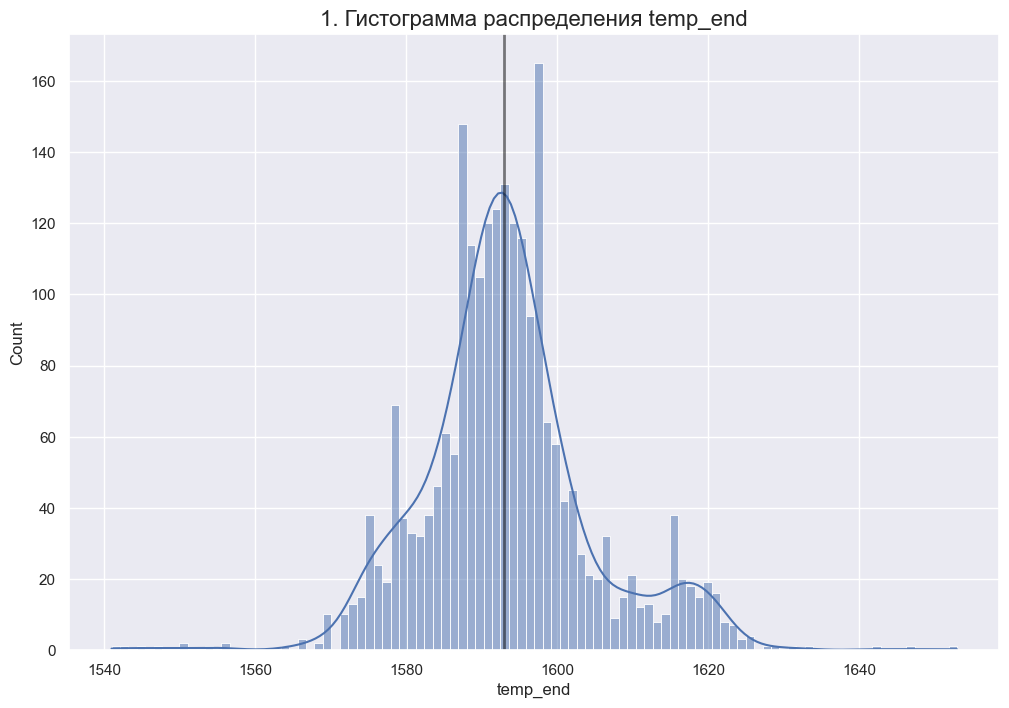

In [98]:
plt.figure(figsize=(12,8))
hist_dist(data_final, 'temp_end', 100, 1)

Распределение таргета близкое к нормальному, сильного дисбаланса нету.

### Корреляционный анализ

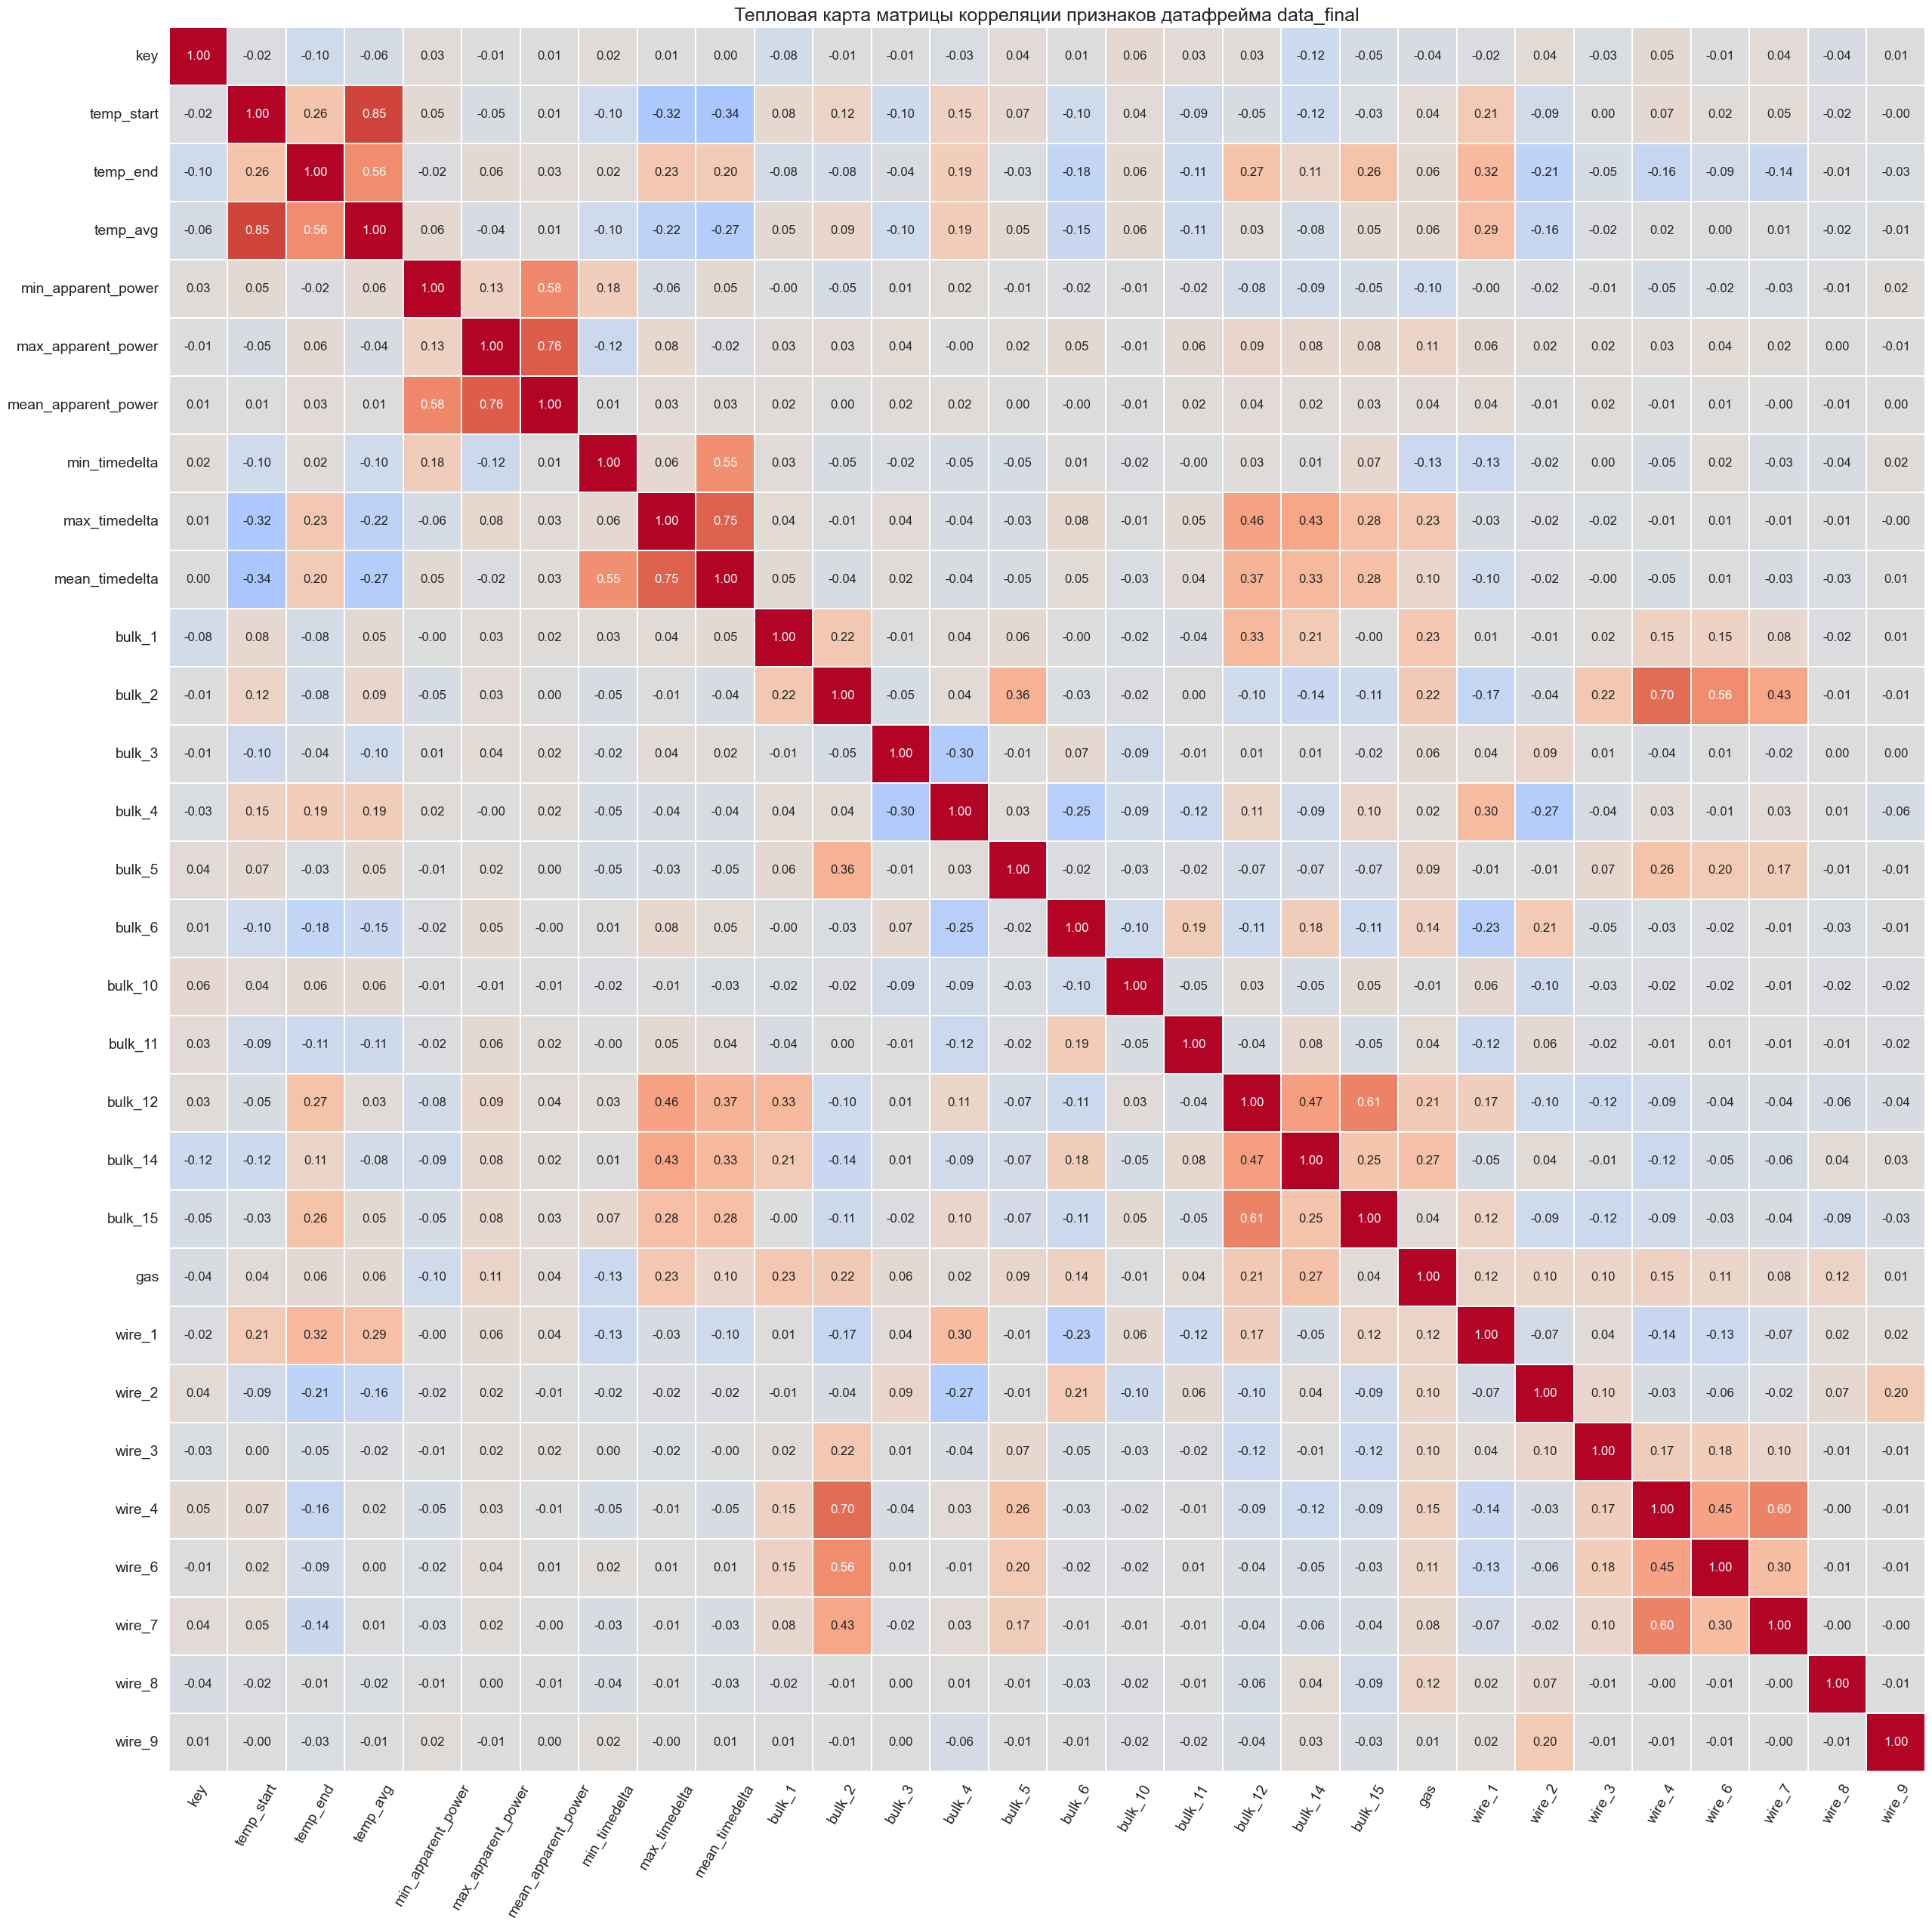

In [99]:
corr_matrix(data_final, 'data_final', (30,30))

Для начала изучим опасные корреляции `> 0.9`. Таких нет.

In [100]:
data_final.drop(['key'], axis=1, inplace=True) # удаляем ключ после проверки

## Подготовка данных

**Создадим функцию `tts` для разделения данных на целевую и тестовую выборку**

In [101]:
def tts(data):
    y = data['temp_end']
    X = data.drop(['temp_end'], axis = 1)
    # разобъём данные по соотношению 4:1
    features_train, features_test, target_train, target_test = train_test_split(X,
                                                                                y,
                                                                                test_size=0.25, 
                                                                                random_state=RANDOM_STATE)
    return features_train, features_test, target_train, target_test

In [102]:
data_features_train, data_features_test, data_target_train, data_target_test = tts(data_final)

In [103]:
# инициализация
scaler = StandardScaler()
# обучение
scaler.fit(data_features_train)

StandardScaler()

In [104]:
# стандартизируем данные
scaled_features_train = scaler.transform(data_features_train)

In [105]:
# создаём датафрейм
scaled_features_train = pd.DataFrame(scaled_features_train, columns = data_features_train.columns)

In [106]:
# стандартизируем данные
scaled_features_test = scaler.transform(data_features_test)
# создаём датафрейм
scaled_features_test = pd.DataFrame(scaled_features_test, columns = data_features_test.columns)

**Данные стандартизированы для линейных моделей.**

## Обучение моделей машинного обучения

### Модель случайного леса

In [107]:
# инициализируем модель
forest_model = RandomForestRegressor(random_state=RANDOM_STATE,
                                     n_estimators=100,
                                     max_depth=4,
                                     verbose=False)

In [108]:
# кросс-валидация
cv_score_forest = cross_val_score(forest_model,
                                  data_features_train,
                                  data_target_train,
                                  scoring='neg_mean_absolute_error',
                                  cv=5)

In [109]:
# оценка модели через кросс-валидацию
mean_cv_score_forest = abs(round(np.mean(cv_score_forest), 2))
print('MAE модели через кросс-валидацию', mean_cv_score_forest)

MAE модели через кросс-валидацию 5.62


In [110]:
# Подберем наилучшие параметры для модели случайного леса
parameters =[{
    

    "n_estimators": np.arange(50, 151, 50),
    'max_depth': np.arange(4, 11, 1)
            }]

forest_model_gs = GridSearchCV(estimator = RandomForestRegressor(random_state=RANDOM_STATE, verbose=False),
                               param_grid = parameters)

In [111]:
%%time
# обучим модель
forest_model_gs.fit(data_features_train, data_target_train)

CPU times: total: 56.7 s
Wall time: 56.7 s


GridSearchCV(estimator=RandomForestRegressor(random_state=121124,
                                             verbose=False),
             param_grid=[{'max_depth': array([ 4,  5,  6,  7,  8,  9, 10]),
                          'n_estimators': array([ 50, 100, 150])}])

In [112]:
# лучшие параметры модели
forest_model_gs.best_params_

{'max_depth': 10, 'n_estimators': 150}

In [113]:
# таблица результатов
pd.DataFrame(forest_model_gs.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,1.075658,0.010581,0.006000,1.907349e-07,10,150,"{'max_depth': 10, 'n_estimators': 150}",0.638699,0.623535,0.597088,0.620032,0.570362,0.609943,0.023855,1
19,0.716800,0.004577,0.004200,4.002094e-04,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.635075,0.618800,0.592515,0.623430,0.569668,0.607898,0.023651,2
17,0.986010,0.007158,0.005000,1.168008e-07,9,150,"{'max_depth': 9, 'n_estimators': 150}",0.638424,0.612476,0.595265,0.618741,0.564732,0.605927,0.024794,3
16,0.654800,0.007625,0.003999,2.025295e-06,9,100,"{'max_depth': 9, 'n_estimators': 100}",0.637603,0.611351,0.590622,0.622539,0.562271,0.604877,0.026243,4
18,0.355615,0.000826,0.002600,4.899209e-04,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.625702,0.608356,0.596617,0.613971,0.566919,0.602313,0.020023,5


In [114]:
# инициируем модель с лучшими параметрами
model_forest_best = forest_model_gs.best_estimator_

In [115]:
model_forest_best.fit(data_features_train, data_target_train)

RandomForestRegressor(max_depth=10, n_estimators=150, random_state=121124,
                      verbose=False)

In [116]:
# оценка модели через кросс-валидацию
cv_score_forest_best = cross_val_score(model_forest_best,
                                       data_features_train,
                                       data_target_train,
                                       scoring='neg_mean_absolute_error',
                                       cv=5)


In [117]:
final_cv_score_forest = abs(round(np.mean(cv_score_forest_best), 2))
print('MAE модели случайного леса с настроенными параметрами через кросс-валидацию', final_cv_score_forest)

MAE модели случайного леса с настроенными параметрами через кросс-валидацию 4.99


#### Важность признаков

In [118]:
explainer = shap.TreeExplainer(model_forest_best)
shap_values = explainer.shap_values(data_features_train)

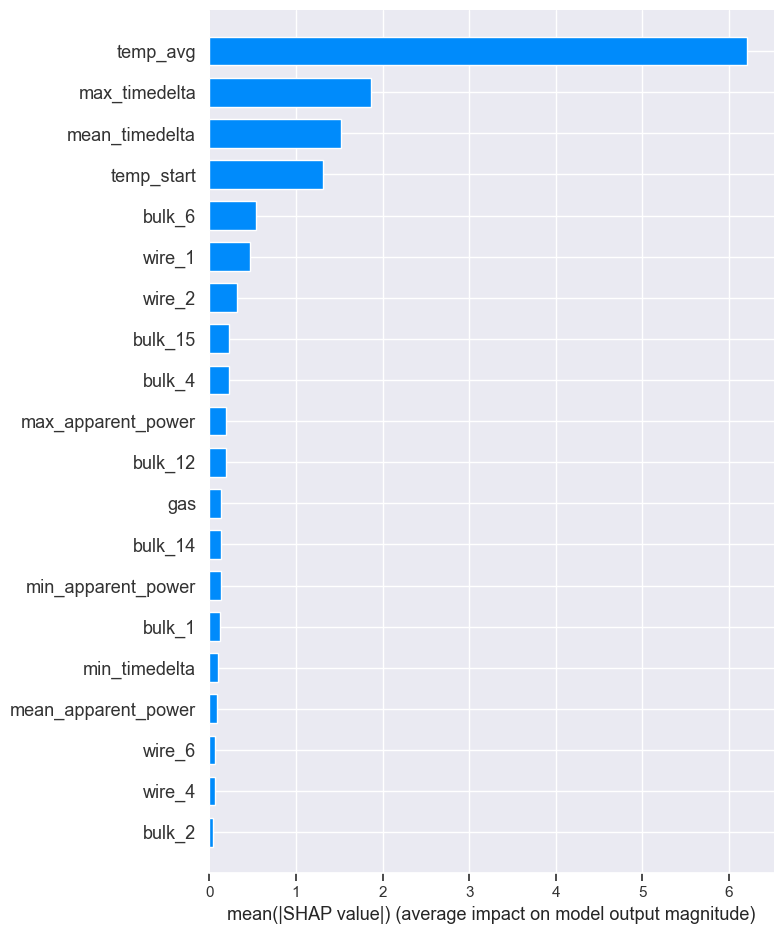

In [119]:
shap.summary_plot(shap_values, data_features_test, plot_type="bar")

### Модель LightGBM

In [120]:
# подготовим данные
train_dataset = lgb.Dataset(data_features_train,
                            data_target_train,
                            free_raw_data=False)

In [121]:
# подготовим данные
valid_dataset = lgb.Dataset(data_features_test,
                            data_target_test,
                            free_raw_data=False)

In [133]:
# параметры модели
params = {
    'boosting_type':'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'n_estimators': 75,
    'max_depth': 10,
    'free_raw_data':False,
    'verbose': 10
}

In [134]:
# обучение с валидацией
evals={}
model_lgbm = lgb.train(params,
                    train_set=train_dataset, 
                    valid_sets=valid_dataset,
                    callbacks = [lgb.record_evaluation(evals)],
                    num_boost_round=10)

[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Unknown parameter: free_raw_data
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pas

In [136]:
#evals_result
evals['valid_0']['l1'][::5]

[7.450753430410223,
 6.1157771064432165,
 5.448418391874016,
 5.0433481265565225,
 4.808400090987224,
 4.692550578254032,
 4.644955391282384,
 4.615525292179688,
 4.605859034889043,
 4.583775827026729,
 4.586714584387658,
 4.581173738762484,
 4.575380722413046,
 4.577949936836578,
 4.602514154192121]

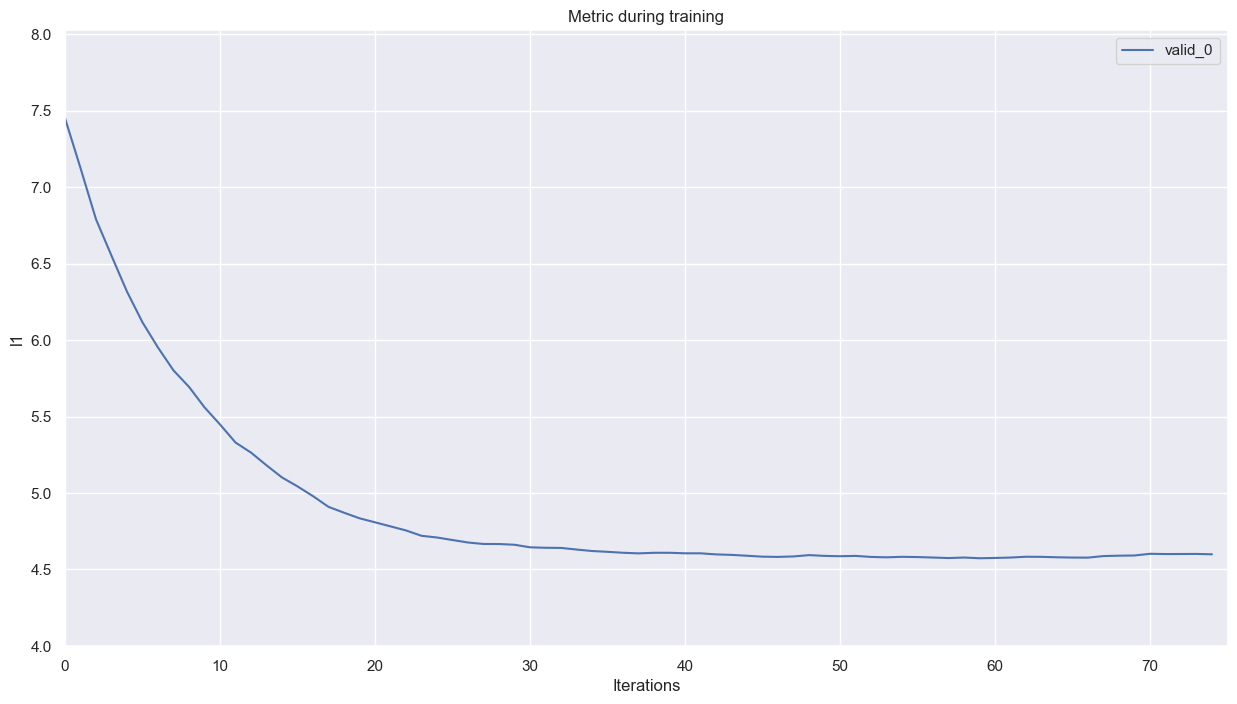

In [137]:
# визуализация обучения
lgb.plot_metric(evals, figsize=(15,8));

#### Важность признаков

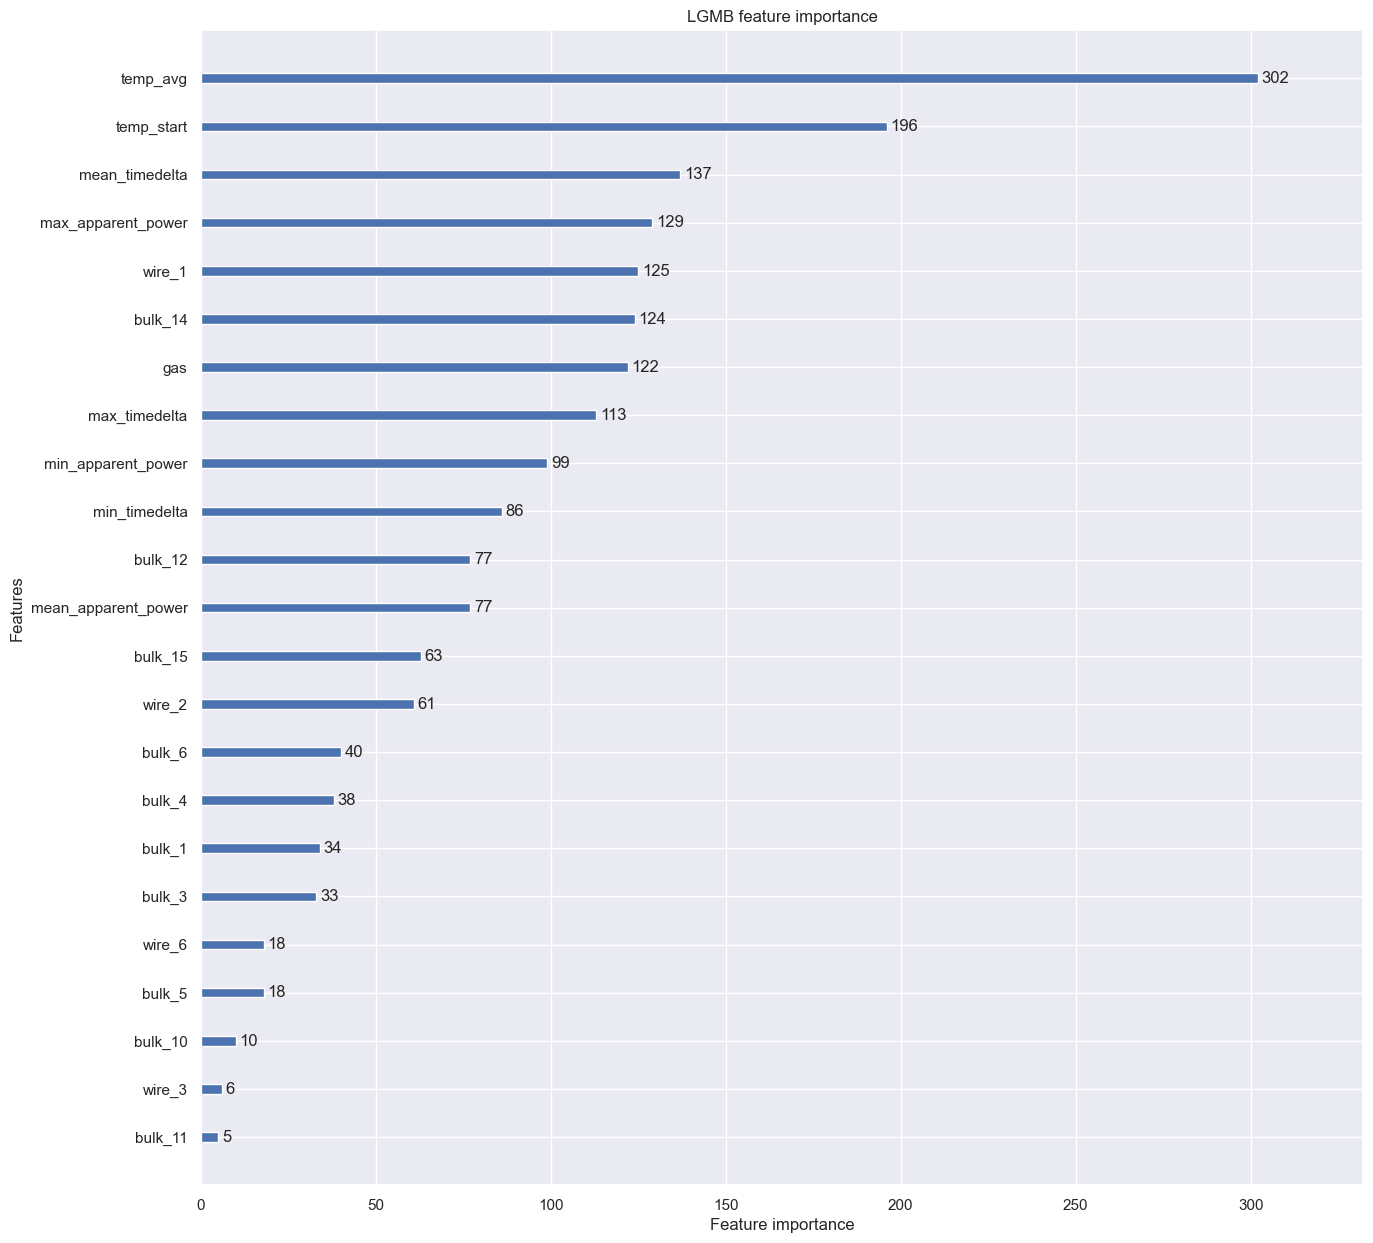

In [138]:
# смотрим важность признаков
lgb.plot_importance(model_lgbm, figsize=(15,15), title='LGMB feature importance');

### Модель CatBoostRegressor

In [139]:
# список категориальных и числовых полей
cat_col = []
num_col = scaled_features_train.columns.to_list()

In [140]:
# инициализируем модель
catboost_model = CatBoostRegressor(random_state=RANDOM_STATE,
                                   loss_function='MAE',
                                   n_estimators=125,
                                   verbose=25)

In [141]:
# оценка модели через кросс-валидацию
cv_score_catboost = cross_val_score(catboost_model,
                                    data_features_train,
                                    data_target_train,
                                    scoring = 'neg_mean_absolute_error',
                                    cv=5)

0:	learn: 7.9789715	total: 152ms	remaining: 18.8s
25:	learn: 6.3895913	total: 181ms	remaining: 689ms
50:	learn: 5.5406244	total: 203ms	remaining: 295ms
75:	learn: 5.0240076	total: 226ms	remaining: 146ms
100:	learn: 4.6934676	total: 248ms	remaining: 58.9ms
124:	learn: 4.4317053	total: 268ms	remaining: 0us
0:	learn: 7.9679657	total: 1.16ms	remaining: 144ms
25:	learn: 6.3035551	total: 23.3ms	remaining: 88.7ms
50:	learn: 5.4058743	total: 44.9ms	remaining: 65.2ms
75:	learn: 4.8712317	total: 67.1ms	remaining: 43.3ms
100:	learn: 4.5254429	total: 90.4ms	remaining: 21.5ms
124:	learn: 4.2811666	total: 111ms	remaining: 0us
0:	learn: 8.0112219	total: 1.22ms	remaining: 152ms
25:	learn: 6.3980156	total: 23.2ms	remaining: 88.2ms
50:	learn: 5.5170351	total: 45.3ms	remaining: 65.7ms
75:	learn: 5.0044125	total: 67.3ms	remaining: 43.4ms
100:	learn: 4.6252584	total: 89ms	remaining: 21.1ms
124:	learn: 4.3903543	total: 110ms	remaining: 0us
0:	learn: 8.0261234	total: 1.17ms	remaining: 146ms
25:	learn: 6.4340

In [142]:
# оценка модели через кросс-валидацию
mean_cv_score_catboost = abs(round(np.mean(cv_score_catboost), 2))
print('MAE модели через кросс-валидацию', mean_cv_score_catboost)

MAE модели через кросс-валидацию 5.19


In [147]:
# поиск лучших гиперпараметров с помощью GridSearchCV
parameters =[{'n_estimators': [100, 259, 500],
              'depth':np.arange(4, 11, 2),
              'learning_rate':[0.1, 0.5, 1]}]

catboost_gs = GridSearchCV(estimator = CatBoostRegressor(loss_function='MAE',
                                                         verbose=False,
                                                         cat_features=cat_col),
                                                         param_grid = parameters)

In [148]:
# обучение модели
catboost_gs.fit(data_features_train, data_target_train)

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x0000023DA7676450>,
             param_grid=[{'depth': array([ 4,  6,  8, 10]),
                          'learning_rate': [0.1, 0.5, 1],
                          'n_estimators': [100, 259, 500]}])

In [149]:
# смотрим наилучшие параметры
catboost_gs.best_params_

{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 500}

In [150]:
# таблица результатов
pd.DataFrame(catboost_gs.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.250944,0.006117,0.0016,4.899987e-04,4,0.1,500,"{'depth': 4, 'learning_rate': 0.1, 'n_estimato...",0.664463,0.596231,0.641630,0.649391,0.587882,0.627920,0.030304,1
1,0.139055,0.008671,0.0012,4.001619e-04,4,0.1,259,"{'depth': 4, 'learning_rate': 0.1, 'n_estimato...",0.660261,0.588074,0.635147,0.649457,0.596596,0.625907,0.028673,2
0,0.060105,0.005425,0.0016,4.900182e-04,4,0.1,100,"{'depth': 4, 'learning_rate': 0.1, 'n_estimato...",0.648446,0.562740,0.625697,0.644740,0.597401,0.615804,0.032110,3
10,0.245164,0.002864,0.0010,3.162980e-07,6,0.1,259,"{'depth': 6, 'learning_rate': 0.1, 'n_estimato...",0.645556,0.590533,0.614381,0.610070,0.602849,0.612678,0.018318,4
11,0.477107,0.015696,0.0014,4.899404e-04,6,0.1,500,"{'depth': 6, 'learning_rate': 0.1, 'n_estimato...",0.639937,0.585049,0.605933,0.600069,0.605975,0.607393,0.017978,5


In [151]:
# реализуем модель с наилучшими параметрами
catboost_model_best = catboost_gs.best_estimator_

In [152]:
# оценка модели через кросс-валидацию
cv_score_catboost_best = cross_val_score(catboost_model_best,
                                         data_features_train,
                                         data_target_train,
                                         scoring = 'neg_mean_absolute_error',
                                         cv=5)

In [153]:
# оценка модели через кросс-валидацию
final_cv_score_catboost = abs(round(np.mean(cv_score_catboost_best), 2))
print('MAE модели catboost с настроенными параметрами через кросс-валидацию', final_cv_score_catboost)

MAE модели catboost с настроенными параметрами через кросс-валидацию 4.93


#### Важность признаков

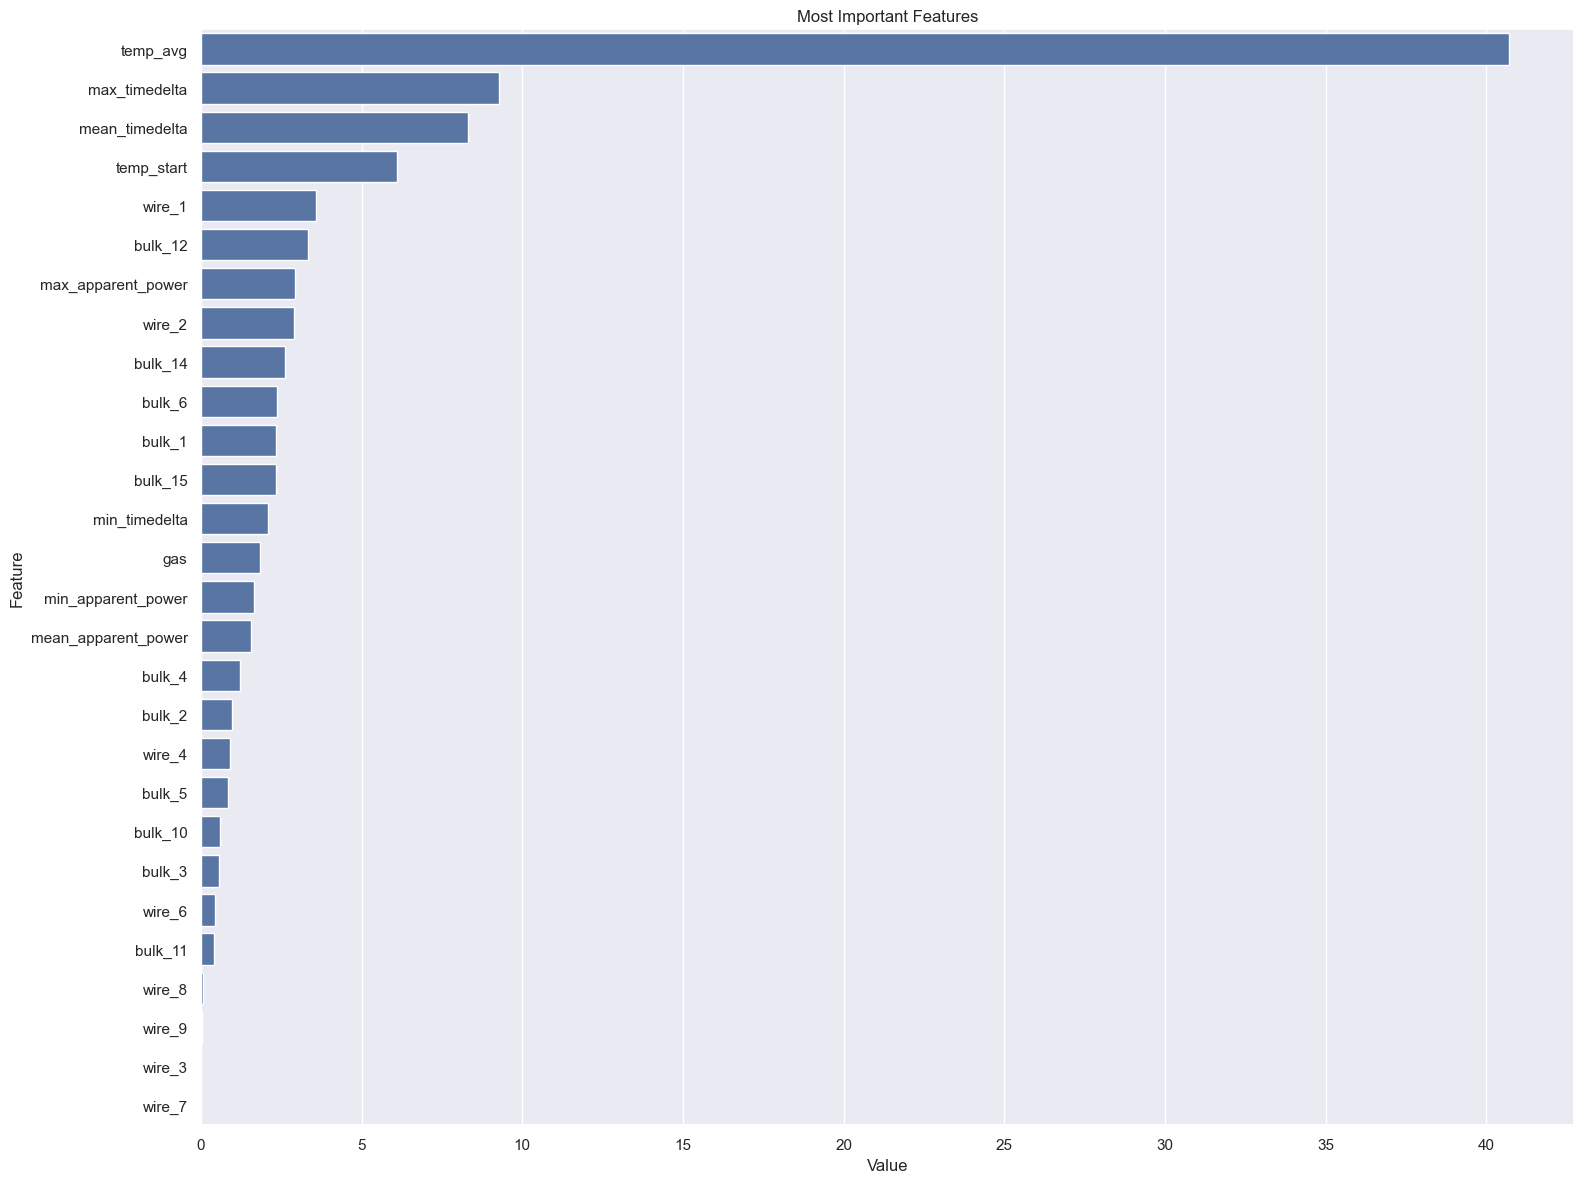

In [154]:
# визуализируем важность признаков
feature_imp = pd.DataFrame((catboost_model_best.feature_importances_), list(data_features_test.columns),columns=['Value'])\
.reset_index().rename(columns={'index':'Feature'})
plt.figure(figsize=(16, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Most Important Features')
plt.tight_layout()
plt.show()

### Linear model

In [155]:
lr_model = LinearRegression()

In [156]:
# оценка модели через кросс-валидацию
cv_score_lr = cross_val_score(lr_model, 
                scaled_features_train, 
                data_target_train,
                scoring='neg_mean_absolute_error',                           
                cv=5)

In [157]:
# оценка модели через кросс-валидацию
mean_cv_score_lr = abs(round(np.mean(cv_score_lr), 2))
print('MAE модели catboost с настроенными параметрами через кросс-валидацию', mean_cv_score_lr)

MAE модели catboost с настроенными параметрами через кросс-валидацию 5.17


### Dummy Regressor

In [158]:
dummy_model = DummyRegressor()

In [159]:
dummy_model.fit(scaled_features_train, data_target_train)
dummy_model

DummyRegressor()

In [160]:
pred = dummy_model.predict(scaled_features_test)

In [161]:
dummy_model_score = mean_absolute_error(pred, data_target_test)
print('MAE константной модели', dummy_model_score)

MAE константной модели 7.885601530349798


## Выбор лучшей модели

В качестве финальной модели выберем `catboost_model_best`

In [162]:
catboost_model_best

In [163]:
# получим предсказания
pred = catboost_model_best.predict(data_features_test)

In [164]:
mae_best_model = mean_absolute_error(pred, data_target_test)
print('MAE модели CatBoostRegressor на тестовых данных', round(mae_best_model, 2))

MAE модели CatBoostRegressor на тестовых данных 4.61


## Общий вывод

Главным параметром для прогнозирования конечной температуры оказалась средняя по процессу (за исключением последней) . Похоже, что для случайного нестационарного процесса предыдущее значение временного ряда — это очень точный прогноз следующего значения.

Модель CatBoostRegressor по качеству оказалась лучше остальных и прошла проверку на адекватность константной моделью.